In [1]:
import math
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import seaborn as sns
from pylab import rcParams
from matplotlib import rc

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, concatenate, LSTM, Input, Bidirectional, Input, Conv1D, MaxPooling1D, Add, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import callbacks
from keras.utils.vis_utils import plot_model

import pmdarima
from pmdarima.metrics import smape

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf


In [2]:
df = pd.read_excel('2021_Interface+RESLocal_1.xls', index_col=[0], parse_dates=[0])

portugal_holidays_csv = pd.read_csv('Holidays.csv')

In [3]:
SAVE_DIR = 'images'

# EDA

In [4]:
df.head()

,Interface [MW],Geração Local [MW]
DATA,,
2021-01-01 00:00:00,19.753853,0.0
2021-01-01 01:00:00,18.472114,0.0
2021-01-01 02:00:00,17.617622,0.0
2021-01-01 03:00:00,16.599771,0.0
2021-01-01 04:00:00,16.298185,0.0


In [5]:
portugal_holidays_csv.head()

,date
0,1970-01-01
1,1970-03-27
2,1970-03-29
3,1970-05-28
4,1970-10-05


In [6]:
pt_2021_holidays = portugal_holidays_csv[pd.to_datetime(portugal_holidays_csv['date']).dt.year==2021]
pt_2021_holidays.head()

,date
647,2021-01-01
648,2021-04-02
649,2021-04-04
650,2021-06-03
651,2021-10-05


In [7]:
pt_2021_holidays.tail()

,date
655,2021-05-01
656,2021-06-10
657,2021-08-15
658,2021-12-08
659,2021-12-25


In [8]:
df.shape

(8712, 2)

In [9]:
# Nans Count
df.isna().sum()

Interface [MW]        0
Geração Local [MW]    0
dtype: int64

In [10]:
# Duplicated Values (based on Date)
df[df.index.isin(df.index[df.index.duplicated()])]

,Interface [MW],Geração Local [MW]
DATA,,
2021-10-31 01:00:00,15.996599,0.0
2021-10-31 01:00:00,15.870939,0.0


In [11]:
# Remove duplicates
df = df[~df.index.duplicated(keep='first')]

In [12]:
df.shape

(8711, 2)

In [13]:
def create_features(df):
    df['Date'] = df.index
    df.reset_index()
    df['Date_Parsed'] = df['Date'].dt.strftime('%Y-%m-%d')
    df['Hour'] = df['Date'].dt.hour
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    df['Quarter'] = df['Date'].dt.quarter
    df['Month'] = df['Date'].dt.month
    df['Year'] = df['Date'].dt.year
    df['DayOfYear'] = df['Date'].dt.dayofyear
    df['DayOfMonth'] = df['Date'].dt.day
    df['WeekOfYear'] = df['Date'].dt.weekofyear
    df['DayOfYearFloat'] = df['DayOfYear'] + df['Hour'] / 24
#     df.drop('Date', axis=1, inplace=True)
    return df

df = create_features(df)
df.head()

,Interface [MW],Geração Local [MW],Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-01-01 00:00:00,19.753853,0.0,2021-01-01 00:00:00,2021-01-01,0,4,1,1,2021,1,1,53,1.000000
2021-01-01 01:00:00,18.472114,0.0,2021-01-01 01:00:00,2021-01-01,1,4,1,1,2021,1,1,53,1.041667
2021-01-01 02:00:00,17.617622,0.0,2021-01-01 02:00:00,2021-01-01,2,4,1,1,2021,1,1,53,1.083333
2021-01-01 03:00:00,16.599771,0.0,2021-01-01 03:00:00,2021-01-01,3,4,1,1,2021,1,1,53,1.125000
2021-01-01 04:00:00,16.298185,0.0,2021-01-01 04:00:00,2021-01-01,4,4,1,1,2021,1,1,53,1.166667


In [14]:
# Rename columns

df.rename(columns = {'Interface [MW]':'Interface', 'Geração Local [MW]':'Local Generation'}, inplace = True)

In [15]:
df.columns

Index(['Interface', 'Local Generation', 'Date', 'Date_Parsed', 'Hour',
       'DayOfWeek', 'Quarter', 'Month', 'Year', 'DayOfYear', 'DayOfMonth',
       'WeekOfYear', 'DayOfYearFloat'],
      dtype='object')

In [16]:
np.unique(df['Year'])

array([2021])

In [17]:
days_of_week_by_month_2021 = df.groupby('Month')['DayOfYear'].agg(['min', 'max', 'count', 'nunique'])
days_of_week_by_month_2021

# It seems that there are values missing in June (One day is missing)
# Missing hour in March (Count!=744 for 31 days as seen below in the next cell)

,min,max,count,nunique
Month,,,,
1,1,31,744,31
2,32,59,672,28
3,60,90,743,31
4,91,120,720,30
5,121,151,744,31
6,152,180,696,29
7,182,212,744,31
8,213,243,744,31
9,244,273,720,30


## Let's find out what's missing in the dataset

In [18]:
df_days = days_of_week_by_month_2021['nunique']

for i in range(len(df_days)):
    print('Expected hours: Month {} -> {}'.format(i+1, df_days[i+1]*24))
    
# March has less an hour than expected

Expected hours: Month 1 -> 744
Expected hours: Month 2 -> 672
Expected hours: Month 3 -> 744
Expected hours: Month 4 -> 720
Expected hours: Month 5 -> 744
Expected hours: Month 6 -> 696
Expected hours: Month 7 -> 744
Expected hours: Month 8 -> 744
Expected hours: Month 9 -> 720
Expected hours: Month 10 -> 744
Expected hours: Month 11 -> 720
Expected hours: Month 12 -> 720


In [19]:
march_hours= df[df['Month']==3].groupby('DayOfMonth')['Hour'].agg(['count', 'nunique'])
march_hours

# Day 28 has less one hour than expected

,count,nunique
DayOfMonth,,
1,24,24
2,24,24
3,24,24
4,24,24
5,24,24
6,24,24
7,24,24
8,24,24
9,24,24


In [20]:
np.unique(df[(df['Month']==3) & (df['DayOfMonth']==28)]['Hour'])

# First hour of March is missing

array([ 0,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])

In [21]:
np.unique(df[df['Month']==6]['Date_Parsed'])

# 30th of June is missing

array(['2021-06-01', '2021-06-02', '2021-06-03', '2021-06-04',
       '2021-06-05', '2021-06-06', '2021-06-07', '2021-06-08',
       '2021-06-09', '2021-06-10', '2021-06-11', '2021-06-12',
       '2021-06-13', '2021-06-14', '2021-06-15', '2021-06-16',
       '2021-06-17', '2021-06-18', '2021-06-19', '2021-06-20',
       '2021-06-21', '2021-06-22', '2021-06-23', '2021-06-24',
       '2021-06-25', '2021-06-26', '2021-06-27', '2021-06-28',
       '2021-06-29'], dtype=object)

In [22]:
np.unique(df[df['Month']==12]['Date_Parsed'])

# 31st of December is missing (Probably not that important)

array(['2021-12-01', '2021-12-02', '2021-12-03', '2021-12-04',
       '2021-12-05', '2021-12-06', '2021-12-07', '2021-12-08',
       '2021-12-09', '2021-12-10', '2021-12-11', '2021-12-12',
       '2021-12-13', '2021-12-14', '2021-12-15', '2021-12-16',
       '2021-12-17', '2021-12-18', '2021-12-19', '2021-12-20',
       '2021-12-21', '2021-12-22', '2021-12-23', '2021-12-24',
       '2021-12-25', '2021-12-26', '2021-12-27', '2021-12-28',
       '2021-12-29', '2021-12-30'], dtype=object)

## Deal with missing data

In [23]:
new_df = df.copy()
new_df = new_df.asfreq('H')
new_df = create_features(new_df)
new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

# Create hours missing in the dataset

,Interface,Local Generation,Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-03-28 00:00:00,18.283623,0.0,2021-03-28 00:00:00,2021-03-28,0,6,1,3,2021,87,28,12,87.000000
2021-03-28 01:00:00,NaN,NaN,2021-03-28 01:00:00,2021-03-28,1,6,1,3,2021,87,28,12,87.041667
2021-03-28 02:00:00,17.693018,0.0,2021-03-28 02:00:00,2021-03-28,2,6,1,3,2021,87,28,12,87.083333
2021-03-28 03:00:00,17.240640,0.0,2021-03-28 03:00:00,2021-03-28,3,6,1,3,2021,87,28,12,87.125000
2021-03-28 04:00:00,17.089847,0.0,2021-03-28 04:00:00,2021-03-28,4,6,1,3,2021,87,28,12,87.166667


In [24]:
new_df['Interface'] = new_df['Interface'].interpolate(method='polynomial', order=2)
new_df['Local Generation'] = new_df['Local Generation'].interpolate(method='polynomial', order=2)
new_df[(new_df['Month']==3)&(new_df['DayOfMonth']==28)].head()

# Polynomial Interpolation (due to the data convex behaviour) in the missing data

,Interface,Local Generation,Date,Date_Parsed,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat
DATA,,,,,,,,,,,,,
2021-03-28 00:00:00,18.283623,0.000000,2021-03-28 00:00:00,2021-03-28,0,6,1,3,2021,87,28,12,87.000000
2021-03-28 01:00:00,18.002523,-0.000027,2021-03-28 01:00:00,2021-03-28,1,6,1,3,2021,87,28,12,87.041667
2021-03-28 02:00:00,17.693018,0.000000,2021-03-28 02:00:00,2021-03-28,2,6,1,3,2021,87,28,12,87.083333
2021-03-28 03:00:00,17.240640,0.000000,2021-03-28 03:00:00,2021-03-28,3,6,1,3,2021,87,28,12,87.125000
2021-03-28 04:00:00,17.089847,0.000000,2021-03-28 04:00:00,2021-03-28,4,6,1,3,2021,87,28,12,87.166667


In [25]:
mask = new_df['DayOfWeek'] <= 4

In [26]:
new_df.loc[mask, 'is_workday'] = 1
new_df.loc[~mask, 'is_workday'] = 0

In [27]:
new_df.drop('Date', axis=1, inplace=True)

In [28]:
new_df.rename(columns = {'Date_Parsed':'date'}, inplace = True)

In [29]:
new_df.shape

(8736, 13)

In [30]:
mask = new_df.assign(result=new_df['date'].isin(pt_2021_holidays['date']))['result']

In [31]:
new_df.loc[mask, 'is_workday'] = 0

# assign 0 if holidays and weekends, and 1 if weekday in the 'is_workday' column

In [32]:
new_df['season_of_year'] = pd.to_datetime(new_df['date']).dt.month%12 // 3 + 1

# assign the season of year column
# starting in the beggining of each month ex: Spring starts at 21st March - We consider it to start at 1st of March
# this analysis was based in the data behaviour seen in the boxplot analysis

In [33]:
new_df[new_df['date']=='2021-03-01'].head()

,Interface,Local Generation,date,Hour,DayOfWeek,Quarter,Month,Year,DayOfYear,DayOfMonth,WeekOfYear,DayOfYearFloat,is_workday,season_of_year
DATA,,,,,,,,,,,,,,
2021-03-01 00:00:00,16.964186,0.0,2021-03-01,0,0,1,3,2021,60,1,9,60.000000,1.0,2
2021-03-01 01:00:00,16.185090,0.0,2021-03-01,1,0,1,3,2021,60,1,9,60.041667,1.0,2
2021-03-01 02:00:00,15.456259,0.0,2021-03-01,2,0,1,3,2021,60,1,9,60.083333,1.0,2
2021-03-01 03:00:00,15.230070,0.0,2021-03-01,3,0,1,3,2021,60,1,9,60.125000,1.0,2
2021-03-01 04:00:00,14.953616,0.0,2021-03-01,4,0,1,3,2021,60,1,9,60.166667,1.0,2


In [34]:
new_df.drop(new_df[new_df['date'] == '2021-12-31'].index, inplace = True)
# Drop day 31st December

# Graphical Analysis

Text(0, 0.5, 'Interface')

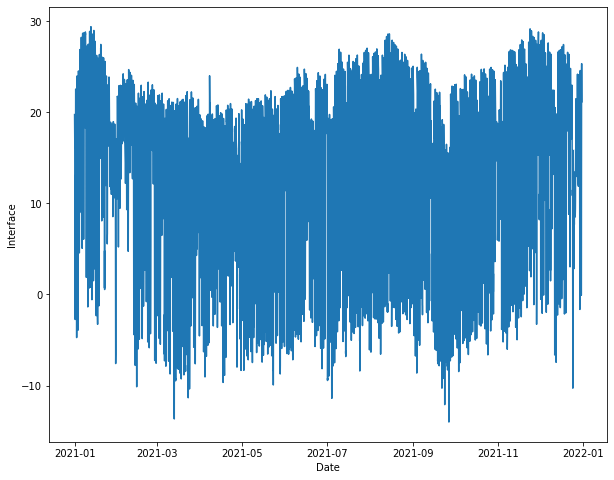

In [35]:
rcParams['figure.figsize'] = 10, 8 # width 10, height 8
# Interface Data
plt.plot(new_df.index, new_df['Interface'])
plt.xlabel("Date")
plt.ylabel("Interface")

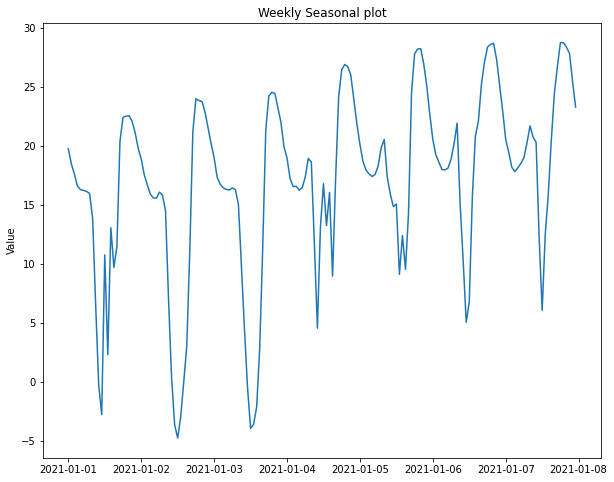

In [36]:
# First week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[:WEEK_END_INDEX], new_df['Interface'][:WEEK_END_INDEX])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.show()

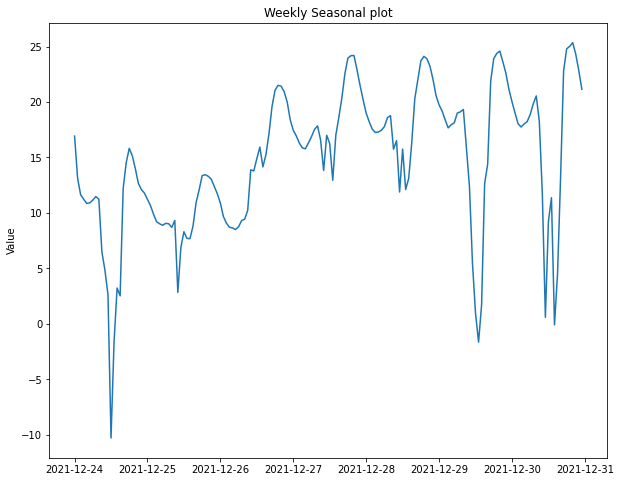

In [37]:
# Last week of the year
WEEK_END_INDEX = 7*24
plt.plot(new_df.index[-WEEK_END_INDEX:], new_df['Interface'][-WEEK_END_INDEX:])
plt.title('Weekly Seasonal plot')
plt.ylabel('Value')
plt.savefig('weekly_saz_plot.png')
plt.show()

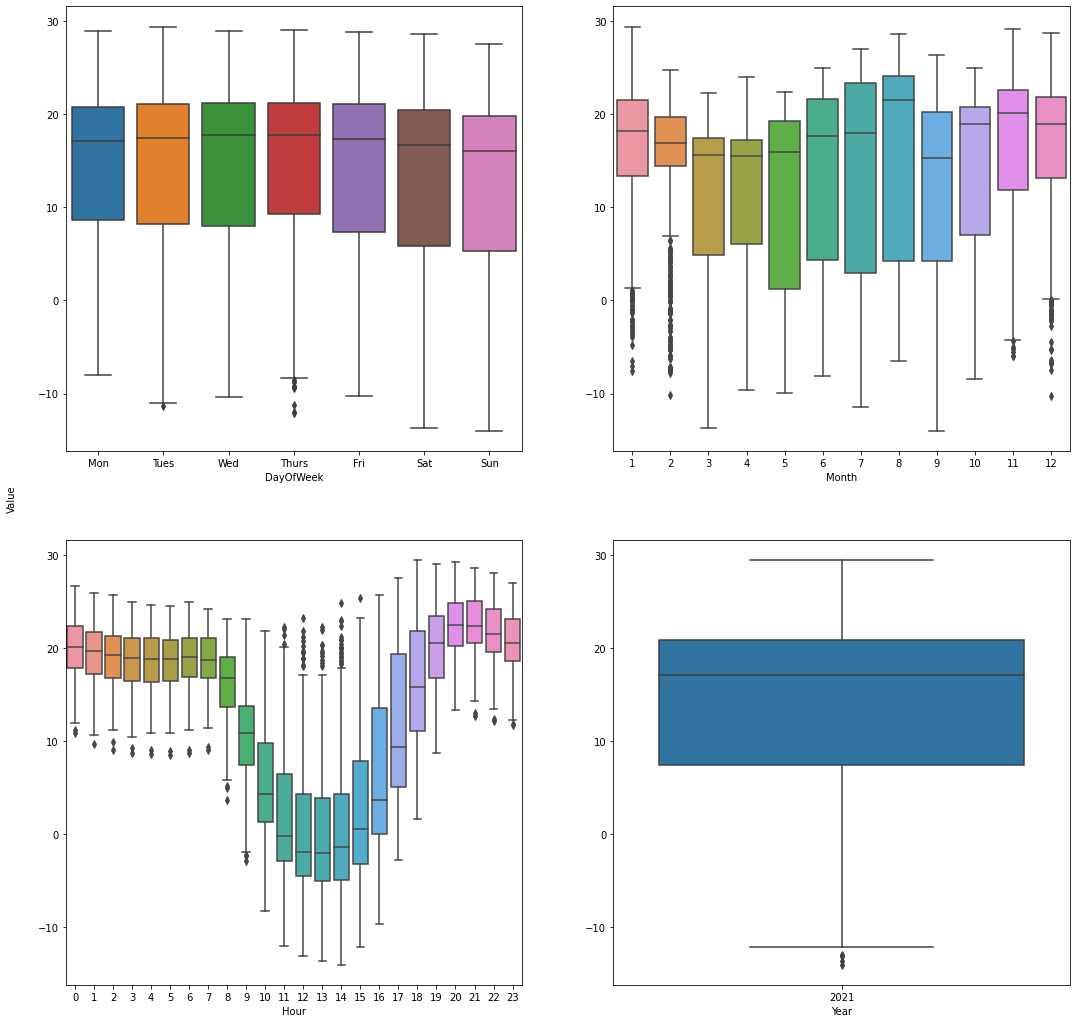

In [38]:
fig, axes = plt.subplots(2, 2, figsize=(18,18))

# Day of Week
dow_labels = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
g = sns.boxplot(x=new_df.DayOfWeek, y=new_df.Interface, ax=axes[0][0])
g.set_xticklabels(dow_labels)
g.set_ylabel('')

# Month of Year
g = sns.boxplot(x=new_df.Month, y=new_df.Interface, ax=axes[0][1])
g.set_ylabel('')

# Hour of Day
g = sns.boxplot(x=new_df.Hour, y=new_df.Interface, ax=axes[1][0])
g.set_ylabel('')

# Year
g = sns.boxplot(x=new_df.Year, y=new_df.Interface, ax=axes[1][1])
g.set_ylabel('')
fig.text(0.08, 0.5, 'Value', va='center', rotation='vertical')
plt.show()

# Several Outliers in Jan, Feb and Dec (Months with more energy consumption due to the cold/smaller days)
# Major problem -> between Mar and Oct (Much of the generated energy was not used)
# 9h - 18h - Tends to generate too much energy (Energy that isn't used by the costumer - Waste/Costly hours)

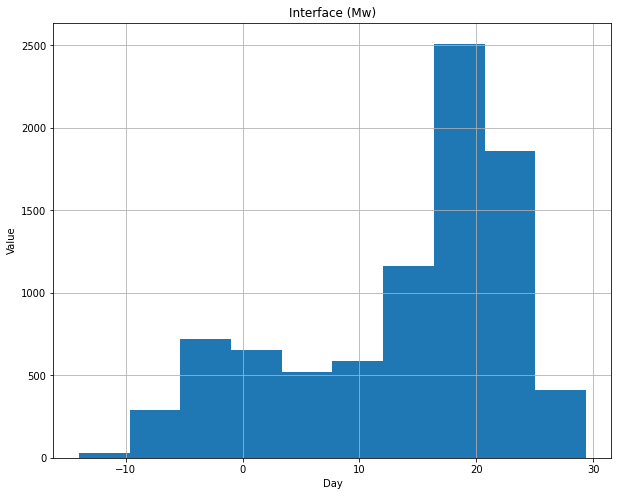

In [39]:
new_df['Interface'].hist()
plt.xlabel('Day')
plt.ylabel('Value')
plt.title('Interface (Mw)')
plt.show()

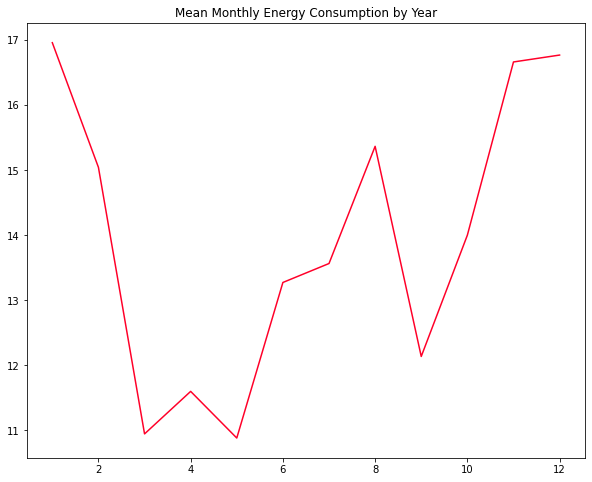

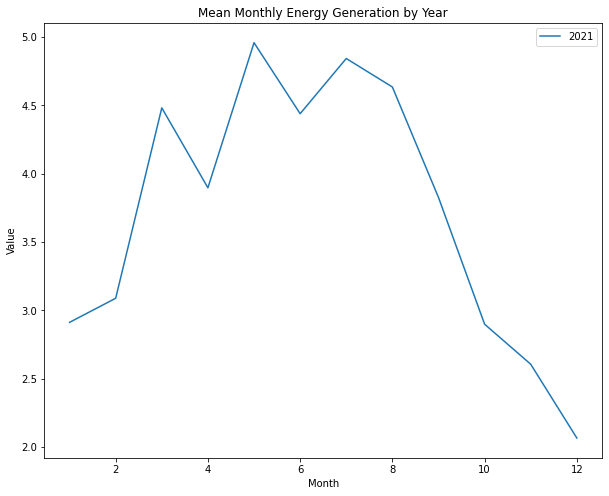

In [40]:
year_group = new_df.groupby(['Year', 'Month']).mean().reset_index()
years = new_df['Year'].unique()
NUM_COLORS = len(years)

cm = plt.get_cmap('gist_rainbow')
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_prop_cycle(color=[cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)])

for i, y in enumerate(years):
    _df = year_group[year_group['Year'] == y]
    plt.title('Mean Monthly Energy Consumption by Year')
    plt.plot(_df['Month'], _df['Interface'])
    plt.show()
    plt.title('Mean Monthly Energy Generation by Year')
    plt.plot(_df['Month'], _df['Local Generation'])
    
plt.xlabel('Month')
plt.ylabel('Value')
plt.legend(new_df.Year.unique())
plt.show()

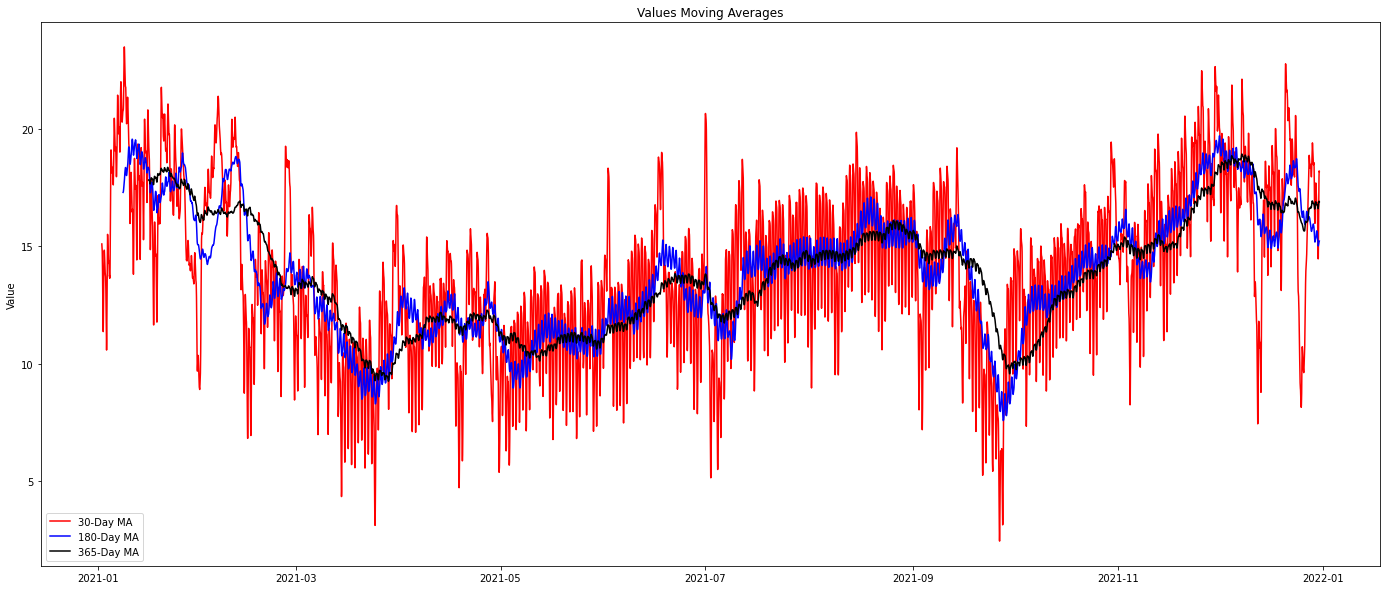

In [41]:
MONTH_PERIOD = 30
MIDYEAR_PERIOD = 182
YEAR_PERIOD = 365

month_roll = new_df['Interface'].rolling(MONTH_PERIOD).mean()
midyear_roll = new_df['Interface'].rolling(MIDYEAR_PERIOD).mean()
year_roll = new_df['Interface'].rolling(YEAR_PERIOD).mean()

fig, ax = plt.subplots(figsize=(24, 10))
plt.plot(month_roll.index, month_roll, color='red', label='30-Day MA')
plt.plot(midyear_roll.index, midyear_roll, color='blue', label='180-Day MA')
plt.plot(year_roll.index, year_roll, color='black', label='365-Day MA')
plt.title('Values Moving Averages')
plt.ylabel('Value')
plt.legend()
plt.show()

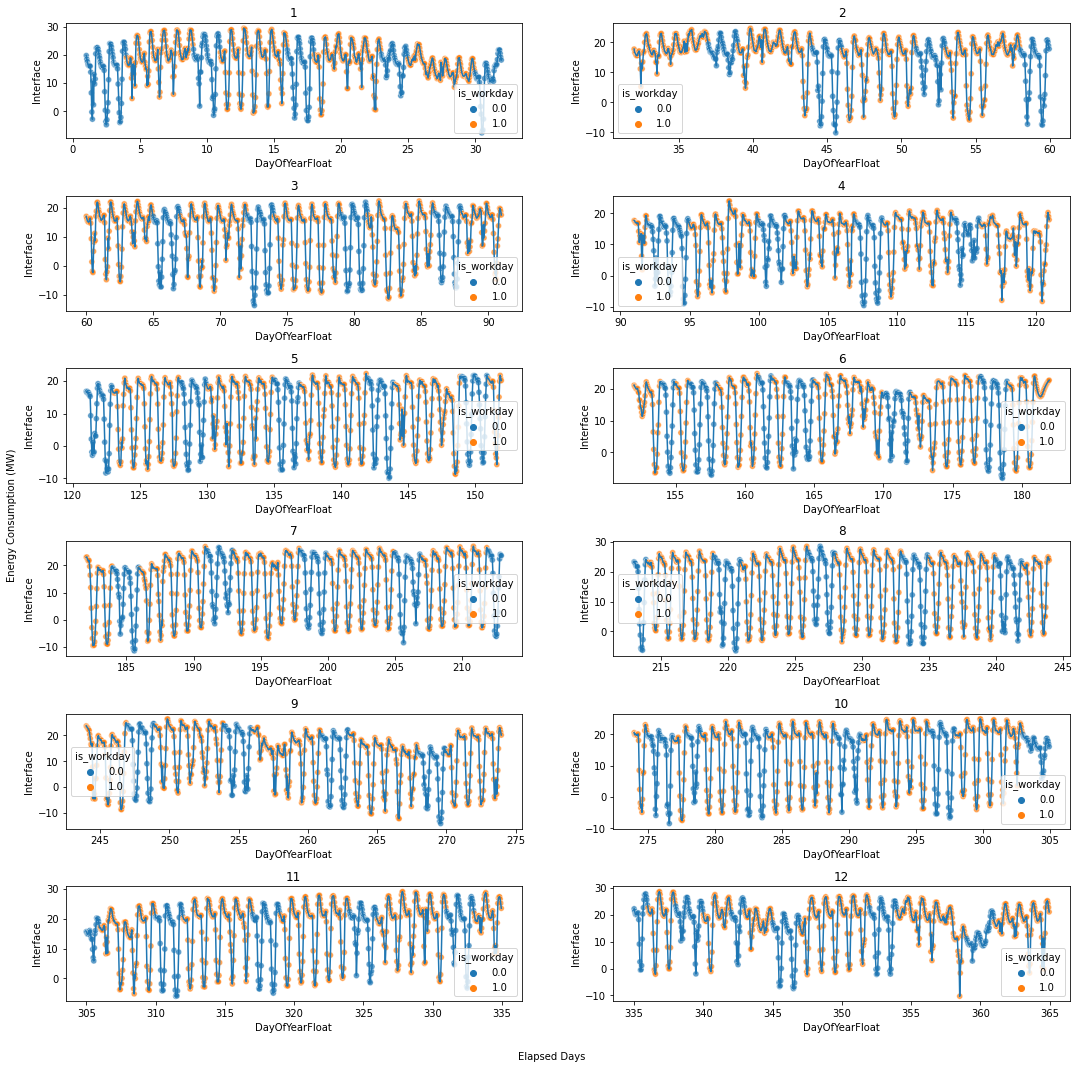

In [42]:
# Monthly Interface Energy Consumption
# Blue color - holidays and weekends
# Orange color - workdays (weekdays that are not holidays)

num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        sns.lineplot(data=df, x='DayOfYearFloat', y='Interface', ax=axes[i,j], palette="flare")
        sns.scatterplot(data=df, x='DayOfYearFloat', y='Interface', alpha=0.7, hue='is_workday', ax=axes[i,j])
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

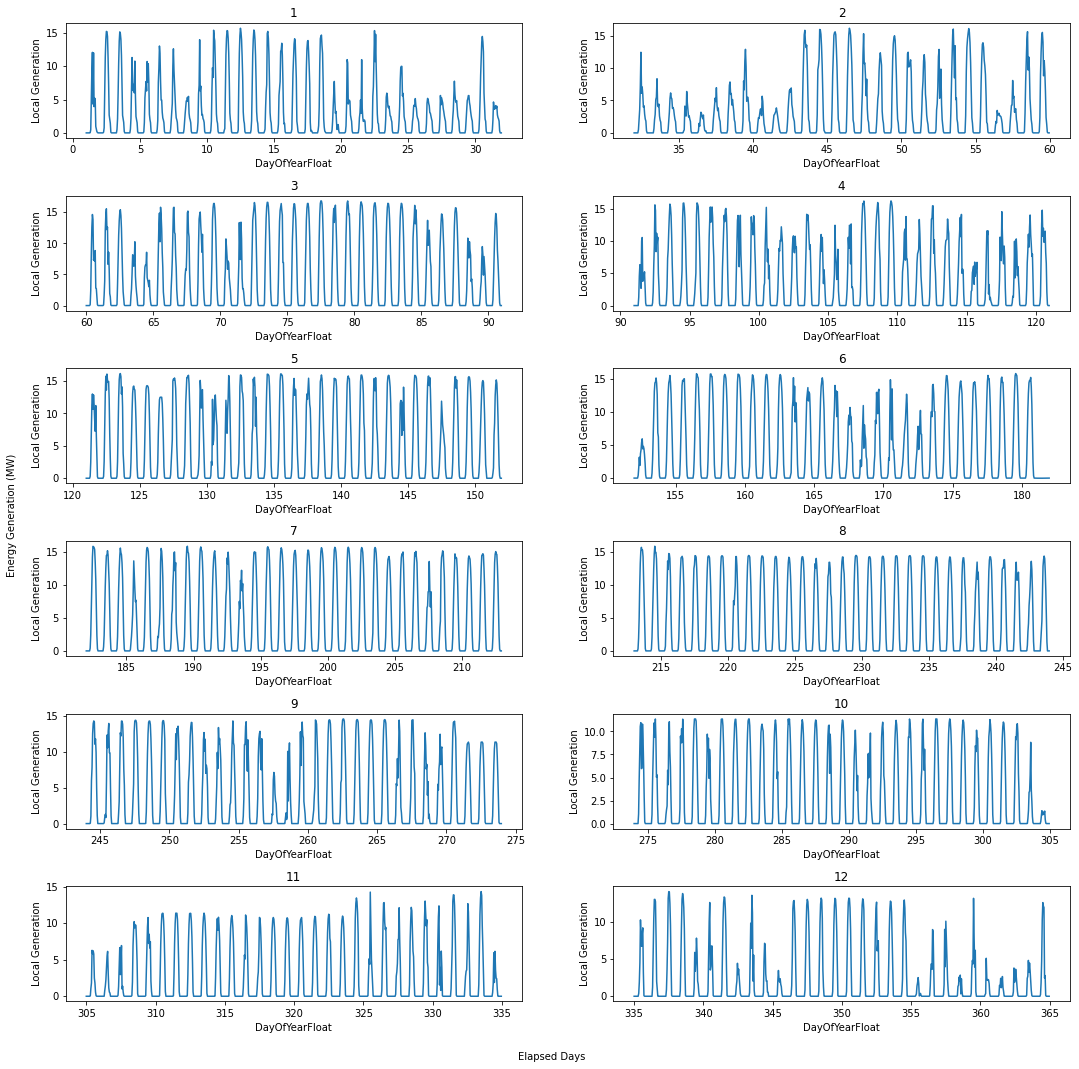

In [43]:
# Local Generation Monthly plot

num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        sns.lineplot(data=df, x='DayOfYearFloat', y='Local Generation', ax=axes[i,j], palette="flare")
#         sns.scatterplot(data=df, x='DayOfYearFloat', y='Local Generation', alpha=0.7, hue='season_of_year', ax=axes[i,j])
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Generation (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

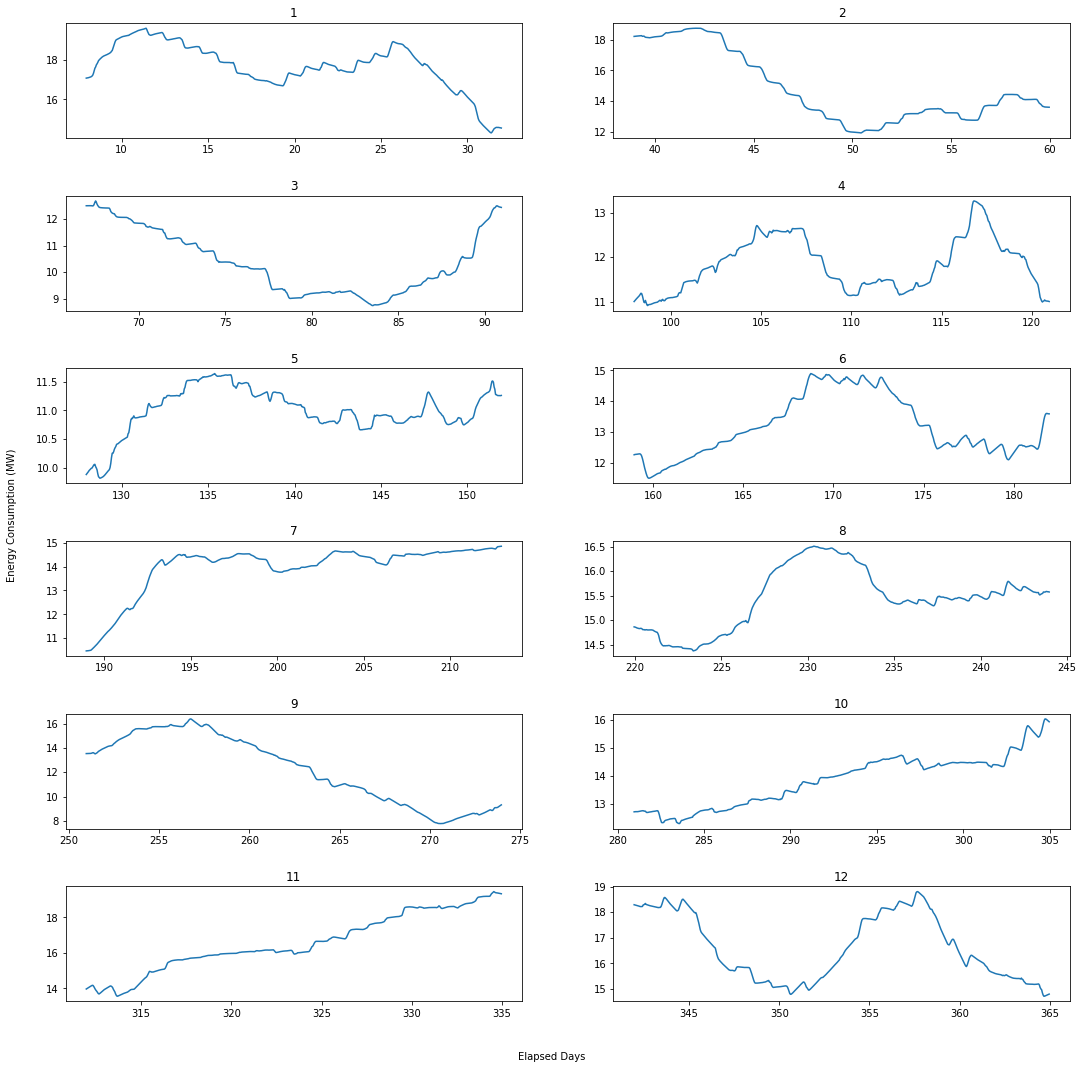

In [44]:
num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        rolling_mean = df['Interface'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Consumption (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

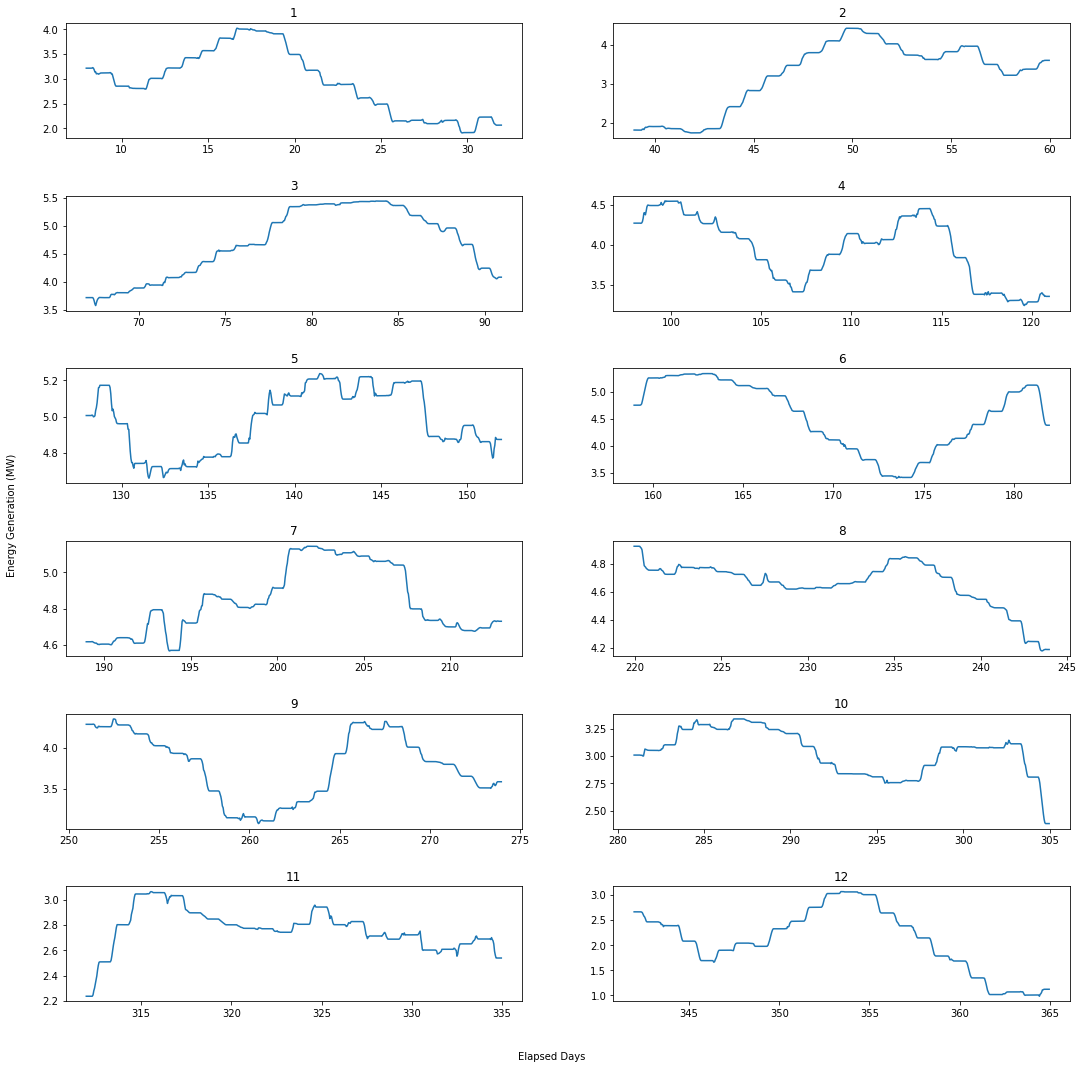

In [45]:
num_rows = 6
num_cols = 2
month_index = 0

fig, axes = plt.subplots(num_rows, num_cols, figsize=(18,18))
months = new_df['Month'].unique()

for i in range(num_rows):
    for j in range(num_cols):
        df = new_df[new_df['Month'] == months[month_index]]
        rolling_mean = df['Local Generation'].rolling(window=7*24).mean()
        axes[i][j].plot(df['DayOfYearFloat'], rolling_mean.values)
        axes[i][j].set_title(str(months[month_index]))
        month_index += 1
        
fig.text(0.5, 0.08, 'Elapsed Days', ha='center')
fig.text(0.08, 0.5, 'Energy Generation (MW)', va='center', rotation='vertical')
fig.subplots_adjust(hspace=0.5)
plt.show()

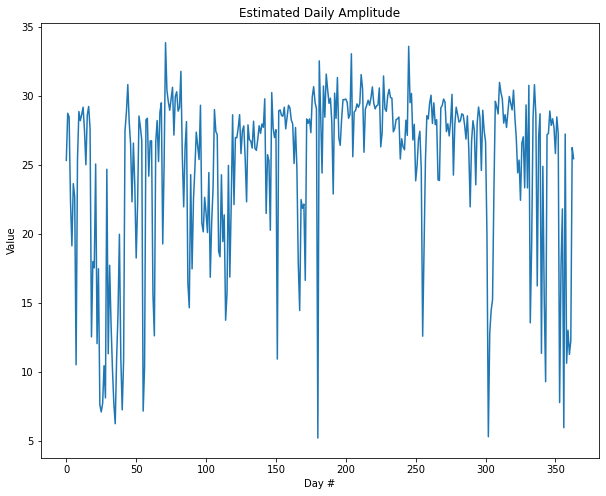

In [46]:
max_daily_vals = new_df.groupby(['Year', 'DayOfYear']).max()['Interface'].values
min_daily_vals = new_df.groupby(['Year', 'DayOfYear']).min()['Interface'].values
daily_amp = max_daily_vals - min_daily_vals
plt.plot(daily_amp)
plt.xlabel('Day #')
plt.ylabel('Value')
plt.title('Estimated Daily Amplitude')
plt.show()

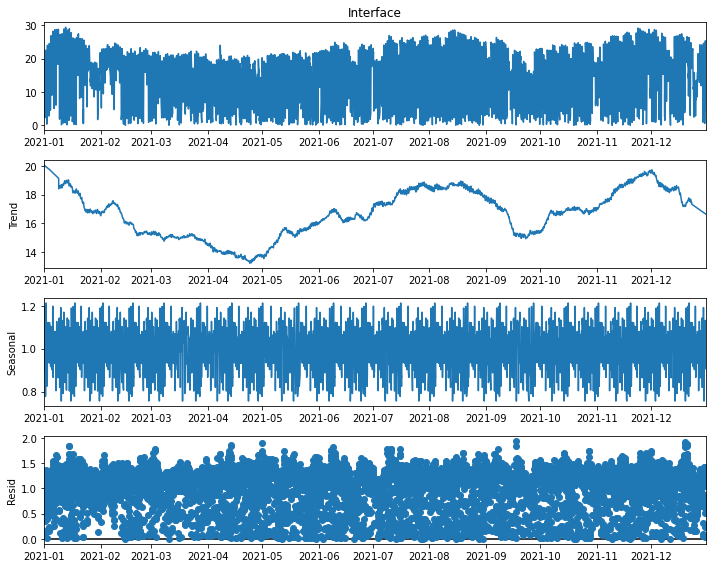

In [47]:
# Seasonal Decomposition

ANNUAL_PERIOD = 365
mult_decomp = seasonal_decompose(new_df[new_df['Interface']>0]['Interface'].dropna(), model='multiplicative', extrapolate_trend='freq', period=ANNUAL_PERIOD)
mult_decomp.plot()
plt.show()

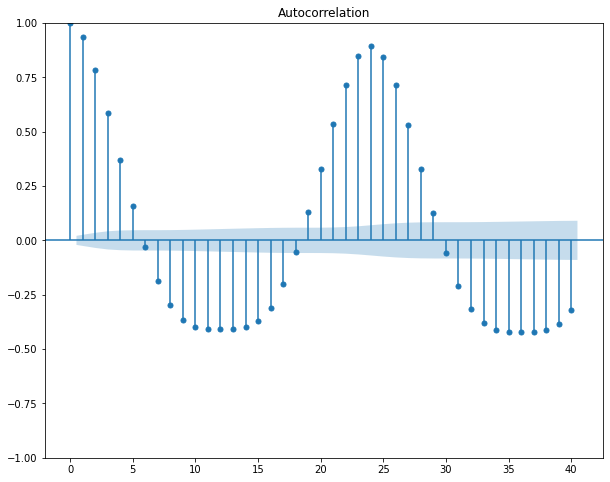

In [48]:
plot_acf(new_df['Interface'], lags=40)
plt.show()

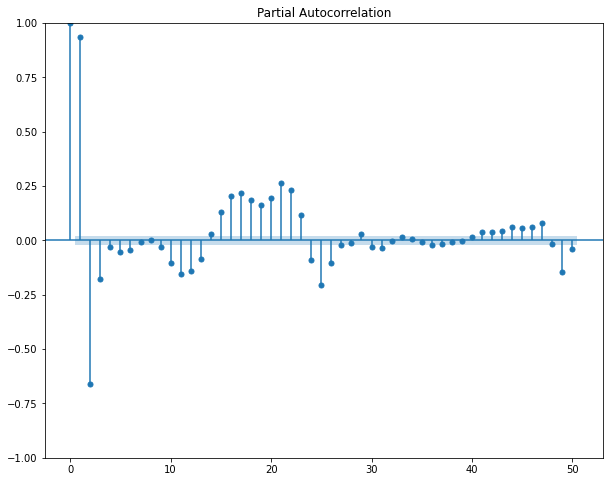

In [49]:
plot_pacf(new_df['Interface'], lags=50)
plt.show()

In [50]:
# PACF and ACF might suggest at least 3 as an AR lag term

# Is the series stationary?

In [51]:
adf_result = adfuller(new_df['Interface'], regression='c')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -8.051125402202592
p-value: 1.74091689822687e-12


In [52]:
adf_result = adfuller(new_df['Local Generation'], regression='c')

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')

ADF Statistic: -7.667310985907191
p-value: 1.628201454125856e-11


In [53]:
# Both series (Interface and Local Generation) are stationary. p-val < 0.05

# Granger Causality Test

In [54]:
grangercausalitytests(new_df[['Interface', 'Local Generation']], maxlag=5)

# p-val < 0.05 - 0. Knowing the Local Generation Values is usefull for Energy Consumption prediction.


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=108.5004, p=0.0000  , df_denom=8732, df_num=1
ssr based chi2 test:   chi2=108.5377, p=0.0000  , df=1
likelihood ratio test: chi2=107.8689, p=0.0000  , df=1
parameter F test:         F=108.5004, p=0.0000  , df_denom=8732, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=147.2554, p=0.0000  , df_denom=8729, df_num=2
ssr based chi2 test:   chi2=294.6795, p=0.0000  , df=2
likelihood ratio test: chi2=289.8174, p=0.0000  , df=2
parameter F test:         F=147.2554, p=0.0000  , df_denom=8729, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=139.3131, p=0.0000  , df_denom=8726, df_num=3
ssr based chi2 test:   chi2=418.2745, p=0.0000  , df=3
likelihood ratio test: chi2=408.5665, p=0.0000  , df=3
parameter F test:         F=139.3131, p=0.0000  , df_denom=8726, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=132.1777, p=0.

{1: ({'ssr_ftest': (108.50040159378142, 2.934897238849956e-25, 8732.0, 1),
   'ssr_chi2test': (108.53767841521767, 2.0491761656665207e-25, 1),
   'lrtest': (107.86888951223955, 2.87159631248502e-25, 1),
   'params_ftest': (108.50040159377585, 2.9348972388572545e-25, 8732.0, 1.0)},
   array([[0., 1., 0.]])]),
 2: ({'ssr_ftest': (147.25541513528844, 1.2675654636423332e-63, 8729.0, 2),
   'ssr_chi2test': (294.6795270458493, 1.0260150637868884e-64, 2),
   'lrtest': (289.8174388607149, 1.1666558732301096e-63, 2),
   'params_ftest': (147.25541513528984, 1.2675654636410364e-63, 8729.0, 2.0)},
   array([[0., 0., 1., 0., 0.],
          [0., 0., 0., 1., 0.]])]),
 3: ({'ssr_ftest': (139.31308938987814, 3.5928073319602e-88, 8726.0, 3),
   'ssr_chi2test': (418.2745391846685, 2.4352482163485462e-90, 3),
   'lrtest': (408.5665064129571, 3.087030534728987e-88, 3),
   'params_ftest': (139.313089389874, 3.5928073319800096e-88, 8726.0, 3.0)},
   array([[0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0.,

In [55]:
data = new_df[['Interface','Local Generation']]

In [56]:
data.head()

,Interface,Local Generation
DATA,,
2021-01-01 00:00:00,19.753853,0.0
2021-01-01 01:00:00,18.472114,0.0
2021-01-01 02:00:00,17.617622,0.0
2021-01-01 03:00:00,16.599771,0.0
2021-01-01 04:00:00,16.298185,0.0


# Train Test Split

In [57]:
train_df = new_df.loc[(new_df.index >= datetime(2021, 1, 1)) & (new_df.index < datetime(2021, 12, 1))][['Interface', 'Local Generation']]
test_df = new_df.loc[(new_df.index >= datetime(2021, 12, 28)) & (new_df.index < datetime(2021, 12, 31))][['Interface', 'Local Generation']]
exogenous_feature_values = list(new_df.loc[(new_df.index >= datetime(2021, 12, 28)) & (new_df.index < datetime(2021, 12, 31))][['Local Generation']].values)

In [58]:
print(train_df.shape, test_df.shape)

(8016, 2) (72, 2)


# Part 1 - Fit Autoarima and Get Residuals

In [59]:
sarima_model_fitted = pmdarima.auto_arima(new_df[['Interface']],
                                         exogenous=new_df[['Local Generation']],
                                         seasonal=True)

p, d, q = sarima_model_fitted.order
sarima_residuals = sarima_model_fitted.arima_res_.resid

In [60]:
sarima_model_fitted

ARIMA(order=(5, 1, 2), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [61]:
sarima_model_fitted.summary()

# Ljung-Box p-val 0.99 > 0.05 - residuals are not auto-correlated
# reject homoskedasticity - the residual series it is not a white noise

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 8736
Model:               SARIMAX(5, 1, 2)   Log Likelihood              -17880.822
Date:                Sun, 19 Jun 2022   AIC                          35779.643
Time:                        12:22:23   BIC                          35843.319
Sample:                    01-01-2021   HQIC                         35801.343
                         - 12-30-2021                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Local Generation    -1.1796      0.008   -148.903      0.000      -1.195      -1.164
ar.L1                1.8849      0.023     82.367      0.000       1.840       1.930
ar.L2               -0.9873      0.025    -38.775      0.000      -1.037      -0.937
ar.L3               -0.0274      0.012     -2.318      0.020      -0.051      -0.004
ar.L4                0.1001      0.012      8.079      0.000       0.076       0.124
ar.L5               -0.0288      0.008     -3.399      0.001      -0.045      -0.012
ma.L1               -1.8052      0.022    -81.518      0.000      -1.849      -1.762
ma.L2                0.8148      0.021     38.121      0.000       0.773       0.857
sigma2               3.5094      0.023    149.892      0.000       3.464       3.555
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):             51877.55
Prob(Q):                              0.99   Prob(JB):                         0.00
Heteroskedasticity (H):               4.84   Skew:                            -0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

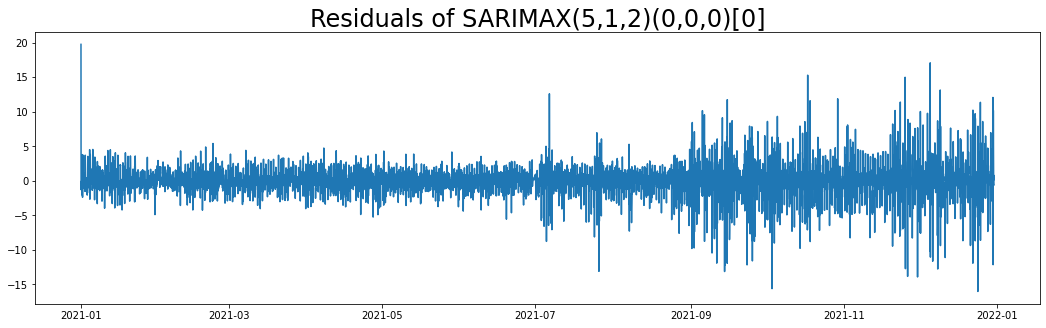

In [62]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX(5,1,2)(0,0,0)[0]", size = 24)
plt.savefig(f'{SAVE_DIR}/sarimax_residuals.png')
plt.show()

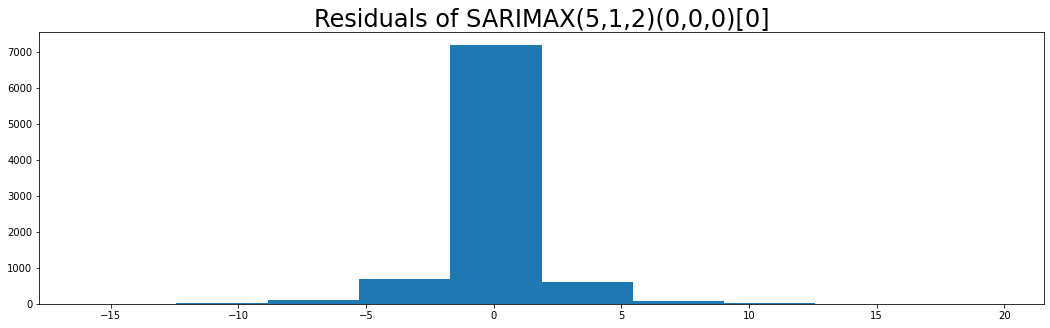

In [63]:
plt.rcParams["figure.figsize"] = 18, 5
plt.hist(sarima_residuals, label = "Residuals")
plt.title("Residuals of SARIMAX(5,1,2)(0,0,0)[0]", size = 24)
plt.show()

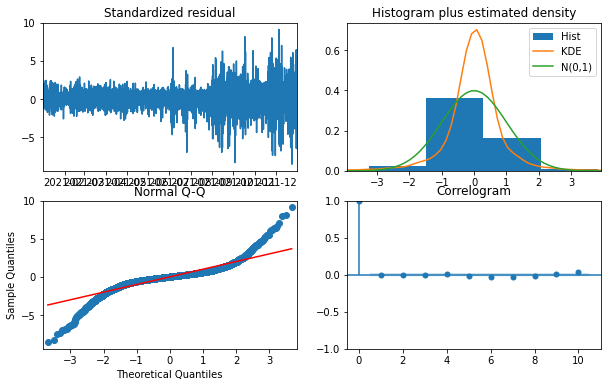

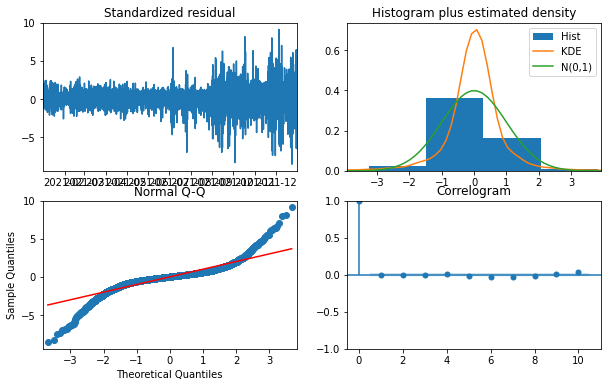

In [64]:
sarima_model_fitted.plot_diagnostics(figsize=(10,6))

In [65]:
# Skewness in the residuals distribution
# Volatility Clusters in the residuals series
# Heteroskedacity in the residuals series

# This said, the model predictions may not be reliable. Thus we need to inspect volatility (Fit a Garch model).

# Forecast Interface - Cross Validation

In [66]:
ar_preds = []
history = [x for x in train_df['Interface'].values]
ex_history = [x for x in train_df[['Local Generation']].values]

for t in range(len(test_df['Interface'].values)):
    model = SARIMAX(history, 
        order=(5,1,2),
        seasonal_order=(0,0,0,0),
        exogenous=ex_history)
    
    model_fit = model.fit()
    output = model_fit.forecast()
    ar_preds.append(output[0])
    history.append(test_df['Interface'].values[t])
    ex_history.append(exogenous_feature_values[t])

ar_pred_series = pd.Series(ar_preds, index=test_df.index)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74652D+00    |proj g|=  1.04633D+00

At iterate    5    f=  2.41706D+00    |proj g|=  7.99011D-02

At iterate   10    f=  2.40683D+00    |proj g|=  9.82690D-03

At iterate   15    f=  2.36417D+00    |proj g|=  4.70392D-02

At iterate   20    f=  2.33536D+00    |proj g|=  2.49954D-02

At iterate   25    f=  2.32541D+00    |proj g|=  4.13119D-03

At iterate   30    f=  2.32505D+00    |proj g|=  2.61256D-04

At iterate   35    f=  2.32505D+00    |proj g|=  2.25415D-04

At iterate   40    f=  2.32503D+00    |proj g|=  5.23096D-03

At iterate   45    f=  2.32494D+00    |proj g|=  2.56854D-03

At iterate   50    f=  2.32470D+00    |proj g|=  2.77548D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74659D+00    |proj g|=  1.04630D+00


 This problem is unconstrained.



At iterate    5    f=  2.41709D+00    |proj g|=  7.98766D-02

At iterate   10    f=  2.40688D+00    |proj g|=  9.81530D-03

At iterate   15    f=  2.36372D+00    |proj g|=  4.82066D-02

At iterate   20    f=  2.33540D+00    |proj g|=  2.62015D-02

At iterate   25    f=  2.32536D+00    |proj g|=  3.70327D-03

At iterate   30    f=  2.32505D+00    |proj g|=  2.80294D-04

At iterate   35    f=  2.32505D+00    |proj g|=  1.23105D-04

At iterate   40    f=  2.32505D+00    |proj g|=  2.95896D-03

At iterate   45    f=  2.32499D+00    |proj g|=  1.61438D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32492D+00    |proj g|=  9.38825D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   9.388D-04   2.325D+00
  F =   2.3249168882666202     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74651D+00    |proj g|=  1.04629D+00


 This problem is unconstrained.



At iterate    5    f=  2.41707D+00    |proj g|=  7.99104D-02

At iterate   10    f=  2.40684D+00    |proj g|=  9.82111D-03

At iterate   15    f=  2.36539D+00    |proj g|=  5.19772D-02

At iterate   20    f=  2.33652D+00    |proj g|=  2.16569D-02

At iterate   25    f=  2.32548D+00    |proj g|=  1.32881D-02

At iterate   30    f=  2.32505D+00    |proj g|=  3.20889D-05

At iterate   35    f=  2.32505D+00    |proj g|=  4.97316D-05

At iterate   40    f=  2.32504D+00    |proj g|=  8.59502D-04

At iterate   45    f=  2.32491D+00    |proj g|=  5.15716D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32466D+00    |proj g|=  4.81468D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   4.815D-03   2.325D+00
  F =   2.3246575169680499     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74645D+00    |proj g|=  1.04631D+00


 This problem is unconstrained.



At iterate    5    f=  2.41701D+00    |proj g|=  7.99301D-02

At iterate   10    f=  2.40678D+00    |proj g|=  9.81711D-03

At iterate   15    f=  2.36549D+00    |proj g|=  5.31800D-02

At iterate   20    f=  2.33645D+00    |proj g|=  2.16942D-02

At iterate   25    f=  2.32542D+00    |proj g|=  1.37958D-02

At iterate   30    f=  2.32499D+00    |proj g|=  2.96747D-05

At iterate   35    f=  2.32499D+00    |proj g|=  1.08168D-04

At iterate   40    f=  2.32498D+00    |proj g|=  1.78073D-03

At iterate   45    f=  2.32489D+00    |proj g|=  3.64215D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32476D+00    |proj g|=  4.94037D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   4.940D-03   2.325D+00
  F =   2.3247592647027844     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74639D+00    |proj g|=  1.04632D+00

At iterate    5    f=  2.41695D+00    |proj g|=  7.99291D-02

At iterate   10    f=  2.40672D+00    |proj g|=  9.81786D-03

At iterate   15    f=  2.36491D+00    |proj g|=  4.94124D-02

At iterate   20    f=  2.33524D+00    |proj g|=  2.22020D-02

At iterate   25    f=  2.32502D+00    |proj g|=  4.27350D-03

At iterate   30    f=  2.32493D+00    |proj g|=  9.85892D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  2.41689D+00    |proj g|=  7.99427D-02

At iterate   10    f=  2.40666D+00    |proj g|=  9.82106D-03

At iterate   15    f=  2.36541D+00    |proj g|=  5.35725D-02

At iterate   20    f=  2.33632D+00    |proj g|=  2.16919D-02

At iterate   25    f=  2.32529D+00    |proj g|=  1.37788D-02

At iterate   30    f=  2.32487D+00    |proj g|=  2.91300D-05

At iterate   35    f=  2.32487D+00    |proj g|=  1.19604D-04

At iterate   40    f=  2.32486D+00    |proj g|=  1.60177D-03

At iterate   45    f=  2.32474D+00    |proj g|=  3.70523D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32452D+00    |proj g|=  2.81241D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     67      1     0     0   2.812D-03   2.325D+00
  F =   2.3245213828654592     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74625D+00    |proj g|=  1.04627D+00

At iterate    5    f=  2.41683D+00    |proj g|=  7.99508D-02

At iterate   10    f=  2.40660D+00    |proj g|=  9.81657D-03

At iterate   15    f=  2.36567D+00    |proj g|=  5.59951D-02

At iterate   20    f=  2.33624D+00    |proj g|=  2.17420D-02

At iterate   25    f=  2.32522D+00    |proj g|=  1.39559D-02

At iterate   30    f=  2.32480D+00    |proj g|=  3.83403D-05

At iterate   35    f=  2.32480D+00    |proj g|=  1.79140D-04

At iterate   40    f=  2.32476D+00    |proj g|=  4.31137D-03

At iterate   45    f=  2.32469D+00    |proj g|=  4.65819D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32418D+00    |proj g|=  4.66856D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     68      1     0     0   4.669D-03   2.324D+00
  F =   2.3241796257090179     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74620D+00    |proj g|=  1.04631D+00

At iterate    5    f=  2.41676D+00    |proj g|=  7.99453D-02

At iterate   10    f=  2.40654D+00    |proj g|=  9.81602D-03

At iterate   15    f=  2.36553D+00    |proj g|=  5.53675D-02

At iterate   20    f=  2.33618D+00    |proj g|=  2.17406D-02

At iterate   25    f=  2.32516D+00    |proj g|=  1.41730D-02

At iterate   30    f=  2.32474D+00    |proj g|=  3.30490D-05

At iterate   35    f=  2.32474D+00    |proj g|=  3.81545D-04

At iterate   40    f=  2.32473D+00    |proj g|=  5.18681D-04

At iterate   45    f=  2.32470D+00    |proj g|=  7.56560D-04


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32453D+00    |proj g|=  3.03076D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   3.031D-03   2.325D+00
  F =   2.3245325790270135     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74614D+00    |proj g|=  1.04630D+00

At iterate    5    f=  2.41670D+00    |proj g|=  7.99464D-02

At iterate   10    f=  2.40648D+00    |proj g|=  9.81864D-03

At iterate   15    f=  2.36554D+00    |proj g|=  5.59215D-02

At iterate   20    f=  2.33611D+00    |proj g|=  2.17580D-02

At iterate   25    f=  2.32510D+00    |proj g|=  1.41977D-02

At iterate   30    f=  2.32468D+00    |proj g|=  3.59555D-05

At iterate   35    f=  2.32468D+00    |proj g|=  3.42460D-04

At iterate   40    f=  2.32466D+00    |proj g|=  4.15858D-03

At iterate   45    f=  2.32458D+00    |proj g|=  2.15521D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32449D+00    |proj g|=  1.94332D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.943D-03   2.324D+00
  F =   2.3244924032387626     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74608D+00    |proj g|=  1.04631D+00

At iterate    5    f=  2.41664D+00    |proj g|=  7.99459D-02

At iterate   10    f=  2.40641D+00    |proj g|=  9.81924D-03

At iterate   15    f=  2.36551D+00    |proj g|=  5.61030D-02

At iterate   20    f=  2.33605D+00    |proj g|=  2.17696D-02

At iterate   25    f=  2.32504D+00    |proj g|=  1.42810D-02

At iterate   30    f=  2.32462D+00    |proj g|=  3.62638D-05

At iterate   35    f=  2.32462D+00    |proj g|=  2.99022D-04

At iterate   40    f=  2.32458D+00    |proj g|=  2.99509D-03

At iterate   45    f=  2.32451D+00    |proj g|=  3.99700D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32443D+00    |proj g|=  2.14074D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     73      1     0     0   2.141D-03   2.324D+00
  F =   2.3244261166444473     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74604D+00    |proj g|=  1.04611D+00

At iterate    5    f=  2.41667D+00    |proj g|=  7.99466D-02

At iterate   10    f=  2.40644D+00    |proj g|=  9.81444D-03

At iterate   15    f=  2.36617D+00    |proj g|=  6.13624D-02

At iterate   20    f=  2.33607D+00    |proj g|=  2.18546D-02

At iterate   25    f=  2.32505D+00    |proj g|=  1.21946D-02

At iterate   30    f=  2.32466D+00    |proj g|=  7.45918D-05

At iterate   35    f=  2.32466D+00    |proj g|=  3.36033D-05

At iterate   40    f=  2.32466D+00    |proj g|=  7.51901D-04

At iterate   45    f=  2.32455D+00    |proj g|=  2.34806D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32436D+00    |proj g|=  9.93058D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   9.931D-03   2.324D+00
  F =   2.3243590273039181     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74593D+00    |proj g|=  1.04592D+00


 This problem is unconstrained.



At iterate    5    f=  2.41667D+00    |proj g|=  7.99505D-02

At iterate   10    f=  2.40644D+00    |proj g|=  9.80788D-03

At iterate   15    f=  2.36563D+00    |proj g|=  5.66665D-02

At iterate   20    f=  2.33608D+00    |proj g|=  2.17840D-02

At iterate   25    f=  2.32506D+00    |proj g|=  1.49044D-02

At iterate   30    f=  2.32464D+00    |proj g|=  3.22394D-05

At iterate   35    f=  2.32464D+00    |proj g|=  1.89359D-04

At iterate   40    f=  2.32464D+00    |proj g|=  8.16684D-04

At iterate   45    f=  2.32457D+00    |proj g|=  2.17958D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32441D+00    |proj g|=  3.67862D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   3.679D-03   2.324D+00
  F =   2.3244082037714171     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74592D+00    |proj g|=  1.04546D+00

At iterate    5    f=  2.41679D+00    |proj g|=  7.99769D-02

At iterate   10    f=  2.40656D+00    |proj g|=  9.79725D-03

At iterate   15    f=  2.36673D+00    |proj g|=  6.60140D-02

At iterate   20    f=  2.33618D+00    |proj g|=  2.19469D-02

At iterate   25    f=  2.32520D+00    |proj g|=  8.95330D-03

At iterate   30    f=  2.32482D+00    |proj g|=  1.20886D-04

At iterate   35    f=  2.32482D+00    |proj g|=  3.51284D-05

At iterate   40    f=  2.32481D+00    |proj g|=  4.84762D-04

At iterate   45    f=  2.32477D+00    |proj g|=  4.40939D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32467D+00    |proj g|=  1.47126D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   1.471D-03   2.325D+00
  F =   2.3246716796289775     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74576D+00    |proj g|=  1.04444D+00


 This problem is unconstrained.



At iterate    5    f=  2.41707D+00    |proj g|=  8.00690D-02

At iterate   10    f=  2.40684D+00    |proj g|=  9.78413D-03

At iterate   15    f=  2.36755D+00    |proj g|=  7.61436D-02

At iterate   20    f=  2.33607D+00    |proj g|=  2.18456D-02

At iterate   25    f=  2.32548D+00    |proj g|=  6.80298D-03

At iterate   30    f=  2.32507D+00    |proj g|=  1.52233D-04

At iterate   35    f=  2.32507D+00    |proj g|=  4.21099D-05

At iterate   40    f=  2.32506D+00    |proj g|=  9.40608D-04

At iterate   45    f=  2.32500D+00    |proj g|=  7.00660D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32487D+00    |proj g|=  6.60479D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   6.605D-03   2.325D+00
  F =   2.3248728443930697     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74564D+00    |proj g|=  1.04367D+00

At iterate    5    f=  2.41728D+00    |proj g|=  8.01228D-02

At iterate   10    f=  2.40704D+00    |proj g|=  9.72921D-03

At iterate   15    f=  2.36800D+00    |proj g|=  8.18645D-02

At iterate   20    f=  2.33585D+00    |proj g|=  2.16506D-02

At iterate   25    f=  2.32563D+00    |proj g|=  4.94259D-03

At iterate   30    f=  2.32530D+00    |proj g|=  4.67075D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.



At iterate    5    f=  2.41726D+00    |proj g|=  8.02446D-02

At iterate   10    f=  2.40702D+00    |proj g|=  9.71650D-03

At iterate   15    f=  2.36839D+00    |proj g|=  8.81262D-02

At iterate   20    f=  2.33510D+00    |proj g|=  2.22305D-02

At iterate   25    f=  2.32558D+00    |proj g|=  7.63076D-03

At iterate   30    f=  2.32526D+00    |proj g|=  5.55310D-04

At iterate   35    f=  2.32526D+00    |proj g|=  8.58264D-05

At iterate   40    f=  2.32525D+00    |proj g|=  3.26389D-03

At iterate   45    f=  2.32514D+00    |proj g|=  3.38300D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32499D+00    |proj g|=  3.61116D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   3.611D-03   2.325D+00
  F =   2.3249932763290766     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74553D+00    |proj g|=  1.04343D+00


 This problem is unconstrained.



At iterate    5    f=  2.41729D+00    |proj g|=  8.01340D-02

At iterate   10    f=  2.40704D+00    |proj g|=  9.73312D-03

At iterate   15    f=  2.36810D+00    |proj g|=  8.36454D-02

At iterate   20    f=  2.33477D+00    |proj g|=  2.04887D-02

At iterate   25    f=  2.32531D+00    |proj g|=  4.74715D-03

At iterate   30    f=  2.32526D+00    |proj g|=  4.42523D-05

At iterate   35    f=  2.32526D+00    |proj g|=  3.46161D-04

At iterate   40    f=  2.32524D+00    |proj g|=  2.15969D-03

At iterate   45    f=  2.32508D+00    |proj g|=  4.74054D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32469D+00    |proj g|=  9.05457D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   9.055D-03   2.325D+00
  F =   2.3246875714129134     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74559D+00    |proj g|=  1.04359D+00


 This problem is unconstrained.



At iterate    5    f=  2.41724D+00    |proj g|=  8.02468D-02

At iterate   10    f=  2.40700D+00    |proj g|=  9.77139D-03

At iterate   15    f=  2.36832D+00    |proj g|=  8.75287D-02

At iterate   20    f=  2.33534D+00    |proj g|=  2.24044D-02

At iterate   25    f=  2.32560D+00    |proj g|=  6.05372D-03

At iterate   30    f=  2.32523D+00    |proj g|=  1.02599D-04

At iterate   35    f=  2.32523D+00    |proj g|=  4.92184D-05

At iterate   40    f=  2.32521D+00    |proj g|=  2.66232D-03

At iterate   45    f=  2.32513D+00    |proj g|=  3.68472D-03

At iterate   50    f=  2.32498D+00    |proj g|=  5.30461D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74555D+00    |proj g|=  1.04369D+00

At iterate    5    f=  2.41719D+00    |proj g|=  8.03528D-02

At iterate   10    f=  2.40694D+00    |proj g|=  9.72049D-03

At iterate   15    f=  2.36854D+00    |proj g|=  8.96321D-02

At iterate   20    f=  2.33499D+00    |proj g|=  4.14031D-02

At iterate   25    f=  2.32551D+00    |proj g|=  1.23560D-02

At iterate   30    f=  2.32517D+00    |proj g|=  4.14839D-04

At iterate   35    f=  2.32517D+00    |proj g|=  1.00790D-04

At iterate   40    f=  2.32516D+00    |proj g|=  1.68637D-03

At iterate   45    f=  2.32503D+00    |proj g|=  2.57438D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32481D+00    |proj g|=  1.07935D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.079D-02   2.325D+00
  F =   2.3248088814082535     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74550D+00    |proj g|=  1.04371D+00


 This problem is unconstrained.



At iterate    5    f=  2.41713D+00    |proj g|=  8.03161D-02

At iterate   10    f=  2.40688D+00    |proj g|=  9.73239D-03

At iterate   15    f=  2.36839D+00    |proj g|=  8.89545D-02

At iterate   20    f=  2.33461D+00    |proj g|=  2.10465D-02

At iterate   25    f=  2.32533D+00    |proj g|=  1.54281D-02

At iterate   30    f=  2.32511D+00    |proj g|=  1.84364D-04

At iterate   35    f=  2.32511D+00    |proj g|=  2.32837D-04

At iterate   40    f=  2.32510D+00    |proj g|=  3.52829D-03

At iterate   45    f=  2.32496D+00    |proj g|=  6.15453D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32481D+00    |proj g|=  3.58972D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     63      1     0     0   3.590D-03   2.325D+00
  F =   2.3248115382484307     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74544D+00    |proj g|=  1.04372D+00


 This problem is unconstrained.



At iterate    5    f=  2.41707D+00    |proj g|=  8.03459D-02

At iterate   10    f=  2.40682D+00    |proj g|=  9.74663D-03

At iterate   15    f=  2.36842D+00    |proj g|=  8.96824D-02

At iterate   20    f=  2.33459D+00    |proj g|=  3.16525D-02

At iterate   25    f=  2.32522D+00    |proj g|=  6.39660D-03

At iterate   30    f=  2.32505D+00    |proj g|=  3.59815D-04

At iterate   35    f=  2.32505D+00    |proj g|=  4.97112D-05

At iterate   40    f=  2.32503D+00    |proj g|=  2.56330D-03

At iterate   45    f=  2.32498D+00    |proj g|=  1.50448D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32478D+00    |proj g|=  4.33070D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   4.331D-03   2.325D+00
  F =   2.3247828696246504     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74537D+00    |proj g|=  1.04372D+00

At iterate    5    f=  2.41701D+00    |proj g|=  8.03599D-02

At iterate   10    f=  2.40675D+00    |proj g|=  9.74493D-03

At iterate   15    f=  2.36841D+00    |proj g|=  9.00242D-02

At iterate   20    f=  2.33493D+00    |proj g|=  4.64042D-02

At iterate   25    f=  2.32522D+00    |proj g|=  1.01131D-02

At iterate   30    f=  2.32499D+00    |proj g|=  2.08354D-04

At iterate   35    f=  2.32499D+00    |proj g|=  1.76382D-04

At iterate   40    f=  2.32497D+00    |proj g|=  3.09735D-03

At iterate   45    f=  2.32483D+00    |proj g|=  2.56377D-03

At iterate   50    f=  2.32462D+00    |proj g|=  7.05955D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74532D+00    |proj g|=  1.04372D+00


 This problem is unconstrained.



At iterate    5    f=  2.41695D+00    |proj g|=  8.03549D-02

At iterate   10    f=  2.40669D+00    |proj g|=  9.74867D-03

At iterate   15    f=  2.36834D+00    |proj g|=  9.00024D-02

At iterate   20    f=  2.33486D+00    |proj g|=  4.59474D-02

At iterate   25    f=  2.32517D+00    |proj g|=  1.03737D-02

At iterate   30    f=  2.32493D+00    |proj g|=  2.20987D-04

At iterate   35    f=  2.32493D+00    |proj g|=  1.46981D-04

At iterate   40    f=  2.32491D+00    |proj g|=  2.96918D-03

At iterate   45    f=  2.32475D+00    |proj g|=  1.23412D-02


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32429D+00    |proj g|=  5.09482D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   5.095D-03   2.324D+00
  F =   2.3242921962249152     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74527D+00    |proj g|=  1.04374D+00

At iterate    5    f=  2.41689D+00    |proj g|=  8.03447D-02

At iterate   10    f=  2.40663D+00    |proj g|=  9.75310D-03

At iterate   15    f=  2.36828D+00    |proj g|=  8.99569D-02

At iterate   20    f=  2.33474D+00    |proj g|=  4.41464D-02

At iterate   25    f=  2.32515D+00    |proj g|=  1.13106D-02

At iterate   30    f=  2.32486D+00    |proj g|=  3.83154D-04

At iterate   35    f=  2.32486D+00    |proj g|=  1.25027D-04

At iterate   40    f=  2.32485D+00    |proj g|=  2.72776D-03

At iterate   45    f=  2.32467D+00    |proj g|=  3.63672D-03

At iterate   50    f=  2.32429D+00    |proj g|=  4.51383D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74522D+00    |proj g|=  1.04376D+00


 This problem is unconstrained.



At iterate    5    f=  2.41683D+00    |proj g|=  8.03369D-02

At iterate   10    f=  2.40657D+00    |proj g|=  9.75497D-03

At iterate   15    f=  2.36823D+00    |proj g|=  9.00448D-02

At iterate   20    f=  2.33478D+00    |proj g|=  4.76030D-02

At iterate   25    f=  2.32502D+00    |proj g|=  9.41606D-03

At iterate   30    f=  2.32480D+00    |proj g|=  3.33492D-04

At iterate   35    f=  2.32480D+00    |proj g|=  1.24539D-04

At iterate   40    f=  2.32479D+00    |proj g|=  3.10912D-03

At iterate   45    f=  2.32463D+00    |proj g|=  4.34528D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32439D+00    |proj g|=  7.00914D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   7.009D-03   2.324D+00
  F =   2.3243916176269019     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74516D+00    |proj g|=  1.04377D+00


 This problem is unconstrained.



At iterate    5    f=  2.41676D+00    |proj g|=  8.03390D-02

At iterate   10    f=  2.40651D+00    |proj g|=  9.75463D-03

At iterate   15    f=  2.36817D+00    |proj g|=  9.00423D-02

At iterate   20    f=  2.33472D+00    |proj g|=  4.77989D-02

At iterate   25    f=  2.32495D+00    |proj g|=  9.29705D-03

At iterate   30    f=  2.32474D+00    |proj g|=  3.39900D-04

At iterate   35    f=  2.32474D+00    |proj g|=  1.45935D-04

At iterate   40    f=  2.32473D+00    |proj g|=  3.02224D-03

At iterate   45    f=  2.32456D+00    |proj g|=  3.85364D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32408D+00    |proj g|=  1.38470D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   1.385D-02   2.324D+00
  F =   2.3240757687238376     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74510D+00    |proj g|=  1.04378D+00

At iterate    5    f=  2.41670D+00    |proj g|=  8.03426D-02

At iterate   10    f=  2.40645D+00    |proj g|=  9.75403D-03

At iterate   15    f=  2.36812D+00    |proj g|=  9.00940D-02

At iterate   20    f=  2.33466D+00    |proj g|=  4.86537D-02

At iterate   25    f=  2.32487D+00    |proj g|=  8.63138D-03

At iterate   30    f=  2.32468D+00    |proj g|=  3.13583D-04

At iterate   35    f=  2.32468D+00    |proj g|=  1.54795D-04

At iterate   40    f=  2.32467D+00    |proj g|=  2.36226D-03

At iterate   45    f=  2.32452D+00    |proj g|=  4.16370D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32435D+00    |proj g|=  2.61831D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   2.618D-03   2.324D+00
  F =   2.3243487030647696     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74505D+00    |proj g|=  1.04380D+00


 This problem is unconstrained.



At iterate    5    f=  2.41664D+00    |proj g|=  8.03412D-02

At iterate   10    f=  2.40639D+00    |proj g|=  9.75116D-03

At iterate   15    f=  2.36804D+00    |proj g|=  8.99664D-02

At iterate   20    f=  2.33453D+00    |proj g|=  4.50119D-02

At iterate   25    f=  2.32489D+00    |proj g|=  1.08794D-02

At iterate   30    f=  2.32462D+00    |proj g|=  3.25485D-04

At iterate   35    f=  2.32462D+00    |proj g|=  1.37040D-04

At iterate   40    f=  2.32456D+00    |proj g|=  1.38999D-03

At iterate   45    f=  2.32438D+00    |proj g|=  4.17955D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32384D+00    |proj g|=  1.19405D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     72      1     0     0   1.194D-02   2.324D+00
  F =   2.3238368030187497     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74498D+00    |proj g|=  1.04378D+00

At iterate    5    f=  2.41658D+00    |proj g|=  8.03472D-02

At iterate   10    f=  2.40633D+00    |proj g|=  9.74924D-03

At iterate   15    f=  2.36799D+00    |proj g|=  9.00480D-02

At iterate   20    f=  2.33453D+00    |proj g|=  4.74113D-02

At iterate   25    f=  2.32478D+00    |proj g|=  9.56625D-03

At iterate   30    f=  2.32456D+00    |proj g|=  3.08816D-04

At iterate   35    f=  2.32456D+00    |proj g|=  1.21989D-04

At iterate   40    f=  2.32454D+00    |proj g|=  3.04691D-03

At iterate   45    f=  2.32438D+00    |proj g|=  2.95109D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32411D+00    |proj g|=  5.20311D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   5.203D-03   2.324D+00
  F =   2.3241137232110614     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74492D+00    |proj g|=  1.04377D+00

At iterate    5    f=  2.41653D+00    |proj g|=  8.03528D-02

At iterate   10    f=  2.40627D+00    |proj g|=  9.75051D-03

At iterate   15    f=  2.36796D+00    |proj g|=  9.02140D-02

At iterate   20    f=  2.33419D+00    |proj g|=  4.64363D-02

At iterate   25    f=  2.32468D+00    |proj g|=  7.93743D-03

At iterate   30    f=  2.32450D+00    |proj g|=  1.21287D-04

At iterate   35    f=  2.32450D+00    |proj g|=  1.51120D-04

At iterate   40    f=  2.32449D+00    |proj g|=  2.21971D-03

At iterate   45    f=  2.32443D+00    |proj g|=  1.11912D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32430D+00    |proj g|=  4.21326D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   4.213D-03   2.324D+00
  F =   2.3243015707851278     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74485D+00    |proj g|=  1.04376D+00


 This problem is unconstrained.



At iterate    5    f=  2.41647D+00    |proj g|=  8.03547D-02

At iterate   10    f=  2.40621D+00    |proj g|=  9.74970D-03

At iterate   15    f=  2.36791D+00    |proj g|=  9.02955D-02

At iterate   20    f=  2.33368D+00    |proj g|=  3.98498D-02

At iterate   25    f=  2.32454D+00    |proj g|=  9.35817D-03

At iterate   30    f=  2.32444D+00    |proj g|=  9.40243D-05

At iterate   35    f=  2.32444D+00    |proj g|=  2.14093D-04

At iterate   40    f=  2.32442D+00    |proj g|=  3.05731D-03

At iterate   45    f=  2.32432D+00    |proj g|=  2.21224D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32407D+00    |proj g|=  4.36907D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   4.369D-03   2.324D+00
  F =   2.3240743167093290     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74481D+00    |proj g|=  1.04379D+00


 This problem is unconstrained.



At iterate    5    f=  2.41641D+00    |proj g|=  8.03527D-02

At iterate   10    f=  2.40615D+00    |proj g|=  9.75059D-03

At iterate   15    f=  2.36784D+00    |proj g|=  9.02392D-02

At iterate   20    f=  2.33388D+00    |proj g|=  4.38822D-02

At iterate   25    f=  2.32456D+00    |proj g|=  1.08393D-02

At iterate   30    f=  2.32438D+00    |proj g|=  2.32445D-04

At iterate   35    f=  2.32438D+00    |proj g|=  1.80409D-04

At iterate   40    f=  2.32437D+00    |proj g|=  2.79401D-03

At iterate   45    f=  2.32429D+00    |proj g|=  2.41753D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32396D+00    |proj g|=  4.56671D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   4.567D-03   2.324D+00
  F =   2.3239642683514257     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74474D+00    |proj g|=  1.04378D+00


 This problem is unconstrained.



At iterate    5    f=  2.41635D+00    |proj g|=  8.03508D-02

At iterate   10    f=  2.40609D+00    |proj g|=  9.74890D-03

At iterate   15    f=  2.36778D+00    |proj g|=  9.02291D-02

At iterate   20    f=  2.33388D+00    |proj g|=  4.47630D-02

At iterate   25    f=  2.32451D+00    |proj g|=  1.01073D-02

At iterate   30    f=  2.32432D+00    |proj g|=  3.14201D-04

At iterate   35    f=  2.32432D+00    |proj g|=  1.64792D-04

At iterate   40    f=  2.32431D+00    |proj g|=  2.27105D-03

At iterate   45    f=  2.32424D+00    |proj g|=  1.00290D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32405D+00    |proj g|=  3.30406D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   3.304D-03   2.324D+00
  F =   2.3240452013689095     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74468D+00    |proj g|=  1.04379D+00

At iterate    5    f=  2.41628D+00    |proj g|=  8.03509D-02

At iterate   10    f=  2.40603D+00    |proj g|=  9.74816D-03

At iterate   15    f=  2.36772D+00    |proj g|=  9.02275D-02

At iterate   20    f=  2.33379D+00    |proj g|=  4.43750D-02

At iterate   25    f=  2.32444D+00    |proj g|=  1.04795D-02

At iterate   30    f=  2.32426D+00    |proj g|=  2.65996D-04

At iterate   35    f=  2.32426D+00    |proj g|=  1.76378D-04

At iterate   40    f=  2.32425D+00    |proj g|=  2.47810D-03

At iterate   45    f=  2.32418D+00    |proj g|=  1.50168D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32397D+00    |proj g|=  3.19811D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   3.198D-03   2.324D+00
  F =   2.3239744255584323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74464D+00    |proj g|=  1.04353D+00

At iterate    5    f=  2.41632D+00    |proj g|=  8.03619D-02

At iterate   10    f=  2.40607D+00    |proj g|=  9.74594D-03

At iterate   15    f=  2.36790D+00    |proj g|=  9.09682D-02

At iterate   20    f=  2.33406D+00    |proj g|=  3.13814D-02

At iterate   25    f=  2.32448D+00    |proj g|=  5.74303D-03

At iterate   30    f=  2.32432D+00    |proj g|=  8.66985D-05

At iterate   35    f=  2.32431D+00    |proj g|=  2.23141D-04

At iterate   40    f=  2.32430D+00    |proj g|=  2.52316D-03

At iterate   45    f=  2.32420D+00    |proj g|=  1.64817D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32413D+00    |proj g|=  1.58819D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.588D-03   2.324D+00
  F =   2.3241336871922775     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74468D+00    |proj g|=  1.04371D+00


 This problem is unconstrained.



At iterate    5    f=  2.41627D+00    |proj g|=  8.03404D-02

At iterate   10    f=  2.40602D+00    |proj g|=  9.74027D-03

At iterate   15    f=  2.36794D+00    |proj g|=  9.12388D-02

At iterate   20    f=  2.33384D+00    |proj g|=  2.35660D-02

At iterate   25    f=  2.32449D+00    |proj g|=  9.28621D-03

At iterate   30    f=  2.32430D+00    |proj g|=  2.02418D-04

At iterate   35    f=  2.32429D+00    |proj g|=  1.33358D-04

At iterate   40    f=  2.32429D+00    |proj g|=  2.35975D-03

At iterate   45    f=  2.32417D+00    |proj g|=  2.11344D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32410D+00    |proj g|=  1.99638D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   1.996D-03   2.324D+00
  F =   2.3240971680927429     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74492D+00    |proj g|=  1.04376D+00


 This problem is unconstrained.



At iterate    5    f=  2.41637D+00    |proj g|=  8.03034D-02

At iterate   10    f=  2.40613D+00    |proj g|=  9.73218D-03

At iterate   15    f=  2.36804D+00    |proj g|=  9.08009D-02

At iterate   20    f=  2.33428D+00    |proj g|=  2.98769D-02

At iterate   25    f=  2.32468D+00    |proj g|=  5.97718D-03

At iterate   30    f=  2.32450D+00    |proj g|=  8.18499D-05

At iterate   35    f=  2.32450D+00    |proj g|=  1.50151D-04

At iterate   40    f=  2.32449D+00    |proj g|=  2.47105D-03

At iterate   45    f=  2.32442D+00    |proj g|=  1.13879D-03

At iterate   50    f=  2.32433D+00    |proj g|=  3.62924D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74503D+00    |proj g|=  1.04431D+00

At iterate    5    f=  2.41631D+00    |proj g|=  8.02876D-02

At iterate   10    f=  2.40607D+00    |proj g|=  9.71671D-03

At iterate   15    f=  2.36799D+00    |proj g|=  9.06793D-02

At iterate   20    f=  2.33421D+00    |proj g|=  2.56437D-02

At iterate   25    f=  2.32466D+00    |proj g|=  5.62583D-03

At iterate   30    f=  2.32447D+00    |proj g|=  1.76335D-04

At iterate   35    f=  2.32447D+00    |proj g|=  5.71389D-05

At iterate   40    f=  2.32447D+00    |proj g|=  1.26329D-03

At iterate   45    f=  2.32437D+00    |proj g|=  4.39656D-03

At iterate   50    f=  2.32419D+00    |proj g|=  2.53463D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74503D+00    |proj g|=  1.04452D+00


 This problem is unconstrained.



At iterate    5    f=  2.41627D+00    |proj g|=  8.03270D-02

At iterate   10    f=  2.40602D+00    |proj g|=  9.73223D-03

At iterate   15    f=  2.36774D+00    |proj g|=  8.95281D-02

At iterate   20    f=  2.33418D+00    |proj g|=  3.77859D-02

At iterate   25    f=  2.32485D+00    |proj g|=  1.35532D-02

At iterate   30    f=  2.32442D+00    |proj g|=  2.92607D-04

At iterate   35    f=  2.32442D+00    |proj g|=  1.75370D-04

At iterate   40    f=  2.32440D+00    |proj g|=  1.84846D-03

At iterate   45    f=  2.32435D+00    |proj g|=  8.98839D-04


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32420D+00    |proj g|=  2.98409D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     66      1     0     0   2.984D-03   2.324D+00
  F =   2.3242028882315409     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74494D+00    |proj g|=  1.04398D+00


 This problem is unconstrained.



At iterate    5    f=  2.41636D+00    |proj g|=  8.05209D-02

At iterate   10    f=  2.40611D+00    |proj g|=  9.81606D-03

At iterate   15    f=  2.39648D+00    |proj g|=  7.68636D-02

At iterate   20    f=  2.33347D+00    |proj g|=  2.05704D-02

At iterate   25    f=  2.32549D+00    |proj g|=  1.27765D-02

At iterate   30    f=  2.32445D+00    |proj g|=  2.25096D-04

At iterate   35    f=  2.32445D+00    |proj g|=  3.36478D-05

At iterate   40    f=  2.32445D+00    |proj g|=  1.49426D-03

At iterate   45    f=  2.32439D+00    |proj g|=  3.05546D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32426D+00    |proj g|=  5.08090D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   5.081D-03   2.324D+00
  F =   2.3242621041108356     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74552D+00    |proj g|=  1.04340D+00


 This problem is unconstrained.



At iterate    5    f=  2.41683D+00    |proj g|=  8.03315D-02

At iterate   10    f=  2.40663D+00    |proj g|=  9.93327D-03

At iterate   15    f=  2.39689D+00    |proj g|=  7.58522D-02

At iterate   20    f=  2.33571D+00    |proj g|=  5.42234D-02

At iterate   25    f=  2.32744D+00    |proj g|=  2.41534D-02

At iterate   30    f=  2.32495D+00    |proj g|=  1.13560D-03

At iterate   35    f=  2.32494D+00    |proj g|=  3.71659D-05

At iterate   40    f=  2.32494D+00    |proj g|=  3.78102D-04

At iterate   45    f=  2.32491D+00    |proj g|=  3.25639D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32472D+00    |proj g|=  4.13343D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   4.133D-03   2.325D+00
  F =   2.3247169748413525     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74527D+00    |proj g|=  1.04312D+00


 This problem is unconstrained.



At iterate    5    f=  2.41707D+00    |proj g|=  7.98832D-02

At iterate   10    f=  2.40688D+00    |proj g|=  9.77410D-03

At iterate   15    f=  2.36784D+00    |proj g|=  7.85716D-02

At iterate   20    f=  2.33608D+00    |proj g|=  2.19483D-02

At iterate   25    f=  2.32554D+00    |proj g|=  5.87364D-03

At iterate   30    f=  2.32522D+00    |proj g|=  1.24063D-04

At iterate   35    f=  2.32522D+00    |proj g|=  9.76469D-05

At iterate   40    f=  2.32521D+00    |proj g|=  2.65895D-03

At iterate   45    f=  2.32511D+00    |proj g|=  2.48756D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32488D+00    |proj g|=  6.15304D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     64      1     0     0   6.153D-03   2.325D+00
  F =   2.3248831449413987     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74557D+00    |proj g|=  1.04293D+00

At iterate    5    f=  2.41725D+00    |proj g|=  7.98216D-02

At iterate   10    f=  2.40706D+00    |proj g|=  9.74560D-03

At iterate   15    f=  2.36803D+00    |proj g|=  7.94901D-02

At iterate   20    f=  2.33615D+00    |proj g|=  2.23526D-02

At iterate   25    f=  2.32556D+00    |proj g|=  7.78357D-03

At iterate   30    f=  2.32531D+00    |proj g|=  1.47494D-04

At iterate   35    f=  2.32531D+00    |proj g|=  1.61627D-04

At iterate   40    f=  2.32530D+00    |proj g|=  3.70786D-03

At iterate   45    f=  2.32519D+00    |proj g|=  3.36233D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32495D+00    |proj g|=  6.57878D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     65      1     0     0   6.579D-03   2.325D+00
  F =   2.3249519355998323     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74552D+00    |proj g|=  1.04314D+00


 This problem is unconstrained.



At iterate    5    f=  2.41722D+00    |proj g|=  7.99757D-02

At iterate   10    f=  2.40701D+00    |proj g|=  9.77215D-03

At iterate   15    f=  2.39737D+00    |proj g|=  7.65186D-02

At iterate   20    f=  2.33630D+00    |proj g|=  3.21797D-02

At iterate   25    f=  2.32714D+00    |proj g|=  2.75911D-02

At iterate   30    f=  2.32531D+00    |proj g|=  6.17890D-04

At iterate   35    f=  2.32531D+00    |proj g|=  5.37193D-05

At iterate   40    f=  2.32531D+00    |proj g|=  1.38590D-03

At iterate   45    f=  2.32528D+00    |proj g|=  4.67693D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32507D+00    |proj g|=  4.49573D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   4.496D-03   2.325D+00
  F =   2.3250697867139554     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74545D+00    |proj g|=  1.04312D+00


 This problem is unconstrained.



At iterate    5    f=  2.41717D+00    |proj g|=  8.01318D-02

At iterate   10    f=  2.40695D+00    |proj g|=  9.82361D-03

At iterate   15    f=  2.39731D+00    |proj g|=  7.65560D-02

At iterate   20    f=  2.33538D+00    |proj g|=  2.57644D-02

At iterate   25    f=  2.32679D+00    |proj g|=  2.15605D-02

At iterate   30    f=  2.32527D+00    |proj g|=  6.04165D-04

At iterate   35    f=  2.32526D+00    |proj g|=  3.03237D-05

At iterate   40    f=  2.32526D+00    |proj g|=  6.98668D-04

At iterate   45    f=  2.32521D+00    |proj g|=  4.06106D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32502D+00    |proj g|=  3.70824D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   3.708D-03   2.325D+00
  F =   2.3250150291549989     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74538D+00    |proj g|=  1.04310D+00

At iterate    5    f=  2.41712D+00    |proj g|=  8.02019D-02

At iterate   10    f=  2.40690D+00    |proj g|=  9.80731D-03

At iterate   15    f=  2.39728D+00    |proj g|=  7.67692D-02

At iterate   20    f=  2.33494D+00    |proj g|=  2.12193D-02

At iterate   25    f=  2.32637D+00    |proj g|=  1.68208D-02

At iterate   30    f=  2.32520D+00    |proj g|=  5.21158D-04

At iterate   35    f=  2.32520D+00    |proj g|=  4.24791D-05

At iterate   40    f=  2.32520D+00    |proj g|=  1.67465D-03

At iterate   45    f=  2.32514D+00    |proj g|=  2.81800D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32506D+00    |proj g|=  3.46350D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   3.464D-03   2.325D+00
  F =   2.3250577077034973     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74531D+00    |proj g|=  1.04305D+00


 This problem is unconstrained.



At iterate    5    f=  2.41706D+00    |proj g|=  8.02302D-02

At iterate   10    f=  2.40684D+00    |proj g|=  9.80544D-03

At iterate   15    f=  2.39715D+00    |proj g|=  7.66572D-02

At iterate   20    f=  2.33481D+00    |proj g|=  3.08565D-02

At iterate   25    f=  2.32643D+00    |proj g|=  7.06252D-03

At iterate   30    f=  2.32514D+00    |proj g|=  3.61920D-04

At iterate   35    f=  2.32514D+00    |proj g|=  2.80746D-05

At iterate   40    f=  2.32514D+00    |proj g|=  9.83137D-04

At iterate   45    f=  2.32508D+00    |proj g|=  4.19732D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32496D+00    |proj g|=  2.06899D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   2.069D-03   2.325D+00
  F =   2.3249571856084654     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74527D+00    |proj g|=  1.04311D+00

At iterate    5    f=  2.41699D+00    |proj g|=  8.01998D-02

At iterate   10    f=  2.40678D+00    |proj g|=  9.79617D-03

At iterate   15    f=  2.39710D+00    |proj g|=  7.67827D-02

At iterate   20    f=  2.33465D+00    |proj g|=  2.81101D-02

At iterate   25    f=  2.32646D+00    |proj g|=  1.03880D-02

At iterate   30    f=  2.32508D+00    |proj g|=  5.59767D-04

At iterate   35    f=  2.32508D+00    |proj g|=  4.01882D-05

At iterate   40    f=  2.32508D+00    |proj g|=  1.23422D-03

At iterate   45    f=  2.32502D+00    |proj g|=  1.52418D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32494D+00    |proj g|=  1.72578D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   1.726D-03   2.325D+00
  F =   2.3249426630514707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74523D+00    |proj g|=  1.04314D+00

At iterate    5    f=  2.41693D+00    |proj g|=  8.01830D-02

At iterate   10    f=  2.40673D+00    |proj g|=  9.79640D-03

At iterate   15    f=  2.39704D+00    |proj g|=  7.67912D-02

At iterate   20    f=  2.33456D+00    |proj g|=  2.62598D-02

At iterate   25    f=  2.32635D+00    |proj g|=  1.31876D-02

At iterate   30    f=  2.32502D+00    |proj g|=  1.82979D-04

At iterate   35    f=  2.32502D+00    |proj g|=  2.81878D-05

At iterate   40    f=  2.32502D+00    |proj g|=  4.55609D-04

At iterate   45    f=  2.32499D+00    |proj g|=  3.25671D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32475D+00    |proj g|=  3.19898D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   3.199D-03   2.325D+00
  F =   2.3247485245061941     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74518D+00    |proj g|=  1.04317D+00

At iterate    5    f=  2.41687D+00    |proj g|=  8.01836D-02

At iterate   10    f=  2.40667D+00    |proj g|=  9.79712D-03

At iterate   15    f=  2.39697D+00    |proj g|=  7.67614D-02

At iterate   20    f=  2.33452D+00    |proj g|=  2.71448D-02

At iterate   25    f=  2.32634D+00    |proj g|=  1.14957D-02

At iterate   30    f=  2.32496D+00    |proj g|=  3.10811D-04

At iterate   35    f=  2.32496D+00    |proj g|=  2.86755D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74512D+00    |proj g|=  1.04318D+00

At iterate    5    f=  2.41681D+00    |proj g|=  8.01853D-02

At iterate   10    f=  2.40661D+00    |proj g|=  9.79472D-03

At iterate   15    f=  2.39691D+00    |proj g|=  7.67898D-02

At iterate   20    f=  2.33445D+00    |proj g|=  2.71101D-02

At iterate   25    f=  2.32628D+00    |proj g|=  1.16129D-02

At iterate   30    f=  2.32490D+00    |proj g|=  2.90940D-04

At iterate   35    f=  2.32490D+00    |proj g|=  2.86887D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.41675D+00    |proj g|=  8.01873D-02

At iterate   10    f=  2.40655D+00    |proj g|=  9.79213D-03

At iterate   15    f=  2.39685D+00    |proj g|=  7.68025D-02

At iterate   20    f=  2.33439D+00    |proj g|=  2.70485D-02

At iterate   25    f=  2.32621D+00    |proj g|=  1.17498D-02

At iterate   30    f=  2.32483D+00    |proj g|=  2.72837D-04

At iterate   35    f=  2.32483D+00    |proj g|=  2.86428D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     42      1     0     0   2.864D-05   2.325D+00
  F =   2.3248341762009970     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.41669D+00    |proj g|=  8.01959D-02

At iterate   10    f=  2.40648D+00    |proj g|=  9.79164D-03

At iterate   15    f=  2.39679D+00    |proj g|=  7.67961D-02

At iterate   20    f=  2.33439D+00    |proj g|=  2.92602D-02

At iterate   25    f=  2.32611D+00    |proj g|=  9.06802D-03

At iterate   30    f=  2.32477D+00    |proj g|=  5.32748D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     34     42      1     0     0   2.938D-05   2.325D+00
  F =   2.3247741384660285     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74495D+00    |proj g|=  1.04320D+00

At iterate    5    f=  2.41663D+00    |proj g|=  8.01986D-02

At iterate   10    f=  2.40642D+00    |proj g|=  9.79359D-03

At iterate   15    f=  2.39672D+00    |proj g|=  7.67711D-02

At iterate   20    f=  2.33435D+00    |proj g|=  2.97982D-02

At iterate   25    f=  2.32603D+00    |proj g|=  8.31165D-03

At iterate   30    f=  2.32472D+00    |proj g|=  5.62583D-04

At iterate   35    f=  2.32472D+00    |proj g|=  2.95544D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.41657D+00    |proj g|=  8.01979D-02

At iterate   10    f=  2.40636D+00    |proj g|=  9.79241D-03

At iterate   15    f=  2.39666D+00    |proj g|=  7.67590D-02

At iterate   20    f=  2.33429D+00    |proj g|=  2.94687D-02

At iterate   25    f=  2.32598D+00    |proj g|=  8.79632D-03

At iterate   30    f=  2.32465D+00    |proj g|=  5.34165D-04

At iterate   35    f=  2.32465D+00    |proj g|=  3.10847D-05

At iterate   40    f=  2.32465D+00    |proj g|=  1.13325D-03

At iterate   45    f=  2.32458D+00    |proj g|=  3.40343D-03

At iterate   50    f=  2.32432D+00    |proj g|=  4.77474D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74481D+00    |proj g|=  1.04316D+00

At iterate    5    f=  2.41651D+00    |proj g|=  8.01983D-02

At iterate   10    f=  2.40630D+00    |proj g|=  9.79253D-03

At iterate   15    f=  2.39660D+00    |proj g|=  7.67362D-02

At iterate   20    f=  2.33426D+00    |proj g|=  3.02714D-02

At iterate   25    f=  2.32590D+00    |proj g|=  7.64097D-03

At iterate   30    f=  2.32460D+00    |proj g|=  4.05218D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nac

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74477D+00    |proj g|=  1.04321D+00

At iterate    5    f=  2.41645D+00    |proj g|=  8.01925D-02

At iterate   10    f=  2.40624D+00    |proj g|=  9.79285D-03

At iterate   15    f=  2.39654D+00    |proj g|=  7.67258D-02

At iterate   20    f=  2.33419D+00    |proj g|=  2.95180D-02

At iterate   25    f=  2.32587D+00    |proj g|=  8.74868D-03

At iterate   30    f=  2.32454D+00    |proj g|=  5.01217D-04

At iterate   35    f=  2.32454D+00    |proj g|=  3.03133D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

 This problem is unconstrained.



At iterate    5    f=  2.41639D+00    |proj g|=  8.01936D-02

At iterate   10    f=  2.40618D+00    |proj g|=  9.79238D-03

At iterate   15    f=  2.39648D+00    |proj g|=  7.67200D-02

At iterate   20    f=  2.33413D+00    |proj g|=  2.95104D-02

At iterate   25    f=  2.32581D+00    |proj g|=  8.77817D-03

At iterate   30    f=  2.32448D+00    |proj g|=  5.01333D-04

At iterate   35    f=  2.32448D+00    |proj g|=  3.04664D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     43      1     0     0   3.047D-05   2.324D+00
  F =   2.3244761989014551     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.41639D+00    |proj g|=  8.01962D-02

At iterate   10    f=  2.40618D+00    |proj g|=  9.79290D-03

At iterate   15    f=  2.39647D+00    |proj g|=  7.66625D-02

At iterate   20    f=  2.33423D+00    |proj g|=  3.22079D-02

At iterate   25    f=  2.32578D+00    |proj g|=  7.85370D-03

At iterate   30    f=  2.32448D+00    |proj g|=  2.52739D-04

At iterate   35    f=  2.32448D+00    |proj g|=  2.87305D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     35     43      1     0     0   2.873D-05   2.324D+00
  F =   2.3244800022402146     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  2.41654D+00    |proj g|=  8.01448D-02

At iterate   10    f=  2.40635D+00    |proj g|=  9.79992D-03

At iterate   15    f=  2.39663D+00    |proj g|=  7.65213D-02

At iterate   20    f=  2.33491D+00    |proj g|=  4.15687D-02

At iterate   25    f=  2.32683D+00    |proj g|=  2.08330D-02

At iterate   30    f=  2.32471D+00    |proj g|=  6.05196D-04

At iterate   35    f=  2.32471D+00    |proj g|=  2.86534D-05

At iterate   40    f=  2.32471D+00    |proj g|=  8.99629D-04

At iterate   45    f=  2.32461D+00    |proj g|=  2.19845D-03

At iterate   50    f=  2.32440D+00    |proj g|=  4.93339D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74552D+00    |proj g|=  1.04321D+00

At iterate    5    f=  2.41685D+00    |proj g|=  8.00085D-02

At iterate   10    f=  2.40669D+00    |proj g|=  9.78160D-03

At iterate   15    f=  2.39702D+00    |proj g|=  7.64203D-02

At iterate   20    f=  2.33578D+00    |proj g|=  4.77748D-02

At iterate   25    f=  2.32773D+00    |proj g|=  2.39864D-02

At iterate   30    f=  2.32529D+00    |proj g|=  9.87328D-04

At iterate   35    f=  2.32529D+00    |proj g|=  2.79083D-05

At iterate   40    f=  2.32529D+00    |proj g|=  4.55184D-04

At iterate   45    f=  2.32522D+00    |proj g|=  4.75271D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32498D+00    |proj g|=  6.78870D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   6.789D-03   2.325D+00
  F =   2.3249836903814112     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74463D+00    |proj g|=  1.03710D+00

At iterate    5    f=  2.41896D+00    |proj g|=  7.99078D-02

At iterate   10    f=  2.40874D+00    |proj g|=  9.76176D-03

At iterate   15    f=  2.37042D+00    |proj g|=  8.86358D-02

At iterate   20    f=  2.33653D+00    |proj g|=  2.36529D-02

At iterate   25    f=  2.32726D+00    |proj g|=  5.78712D-03

At iterate   30    f=  2.32711D+00    |proj g|=  9.34739D-05

At iterate   35    f=  2.32711D+00    |proj g|=  1.39835D-04

At iterate   40    f=  2.32711D+00    |proj g|=  1.84384D-03

At iterate   45    f=  2.32701D+00    |proj g|=  2.35885D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32680D+00    |proj g|=  4.80979D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   4.810D-03   2.327D+00
  F =   2.3268019630695287     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74458D+00    |proj g|=  1.03735D+00


 This problem is unconstrained.



At iterate    5    f=  2.41893D+00    |proj g|=  8.01179D-02

At iterate   10    f=  2.40871D+00    |proj g|=  9.66793D-03

At iterate   15    f=  2.39866D+00    |proj g|=  7.54421D-02

At iterate   20    f=  2.33739D+00    |proj g|=  2.97949D-02

At iterate   25    f=  2.32879D+00    |proj g|=  1.87980D-02

At iterate   30    f=  2.32708D+00    |proj g|=  5.51843D-04

At iterate   35    f=  2.32708D+00    |proj g|=  3.50543D-05

At iterate   40    f=  2.32708D+00    |proj g|=  2.56350D-04

At iterate   45    f=  2.32707D+00    |proj g|=  2.35917D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32700D+00    |proj g|=  1.05687D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   1.057D-03   2.327D+00
  F =   2.3270027748490278     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74437D+00    |proj g|=  1.03304D+00


 This problem is unconstrained.



At iterate    5    f=  2.42155D+00    |proj g|=  9.10106D-02

At iterate   10    f=  2.41074D+00    |proj g|=  1.20535D-02

At iterate   15    f=  2.39750D+00    |proj g|=  9.40101D-02

At iterate   20    f=  2.34479D+00    |proj g|=  2.44757D-02

At iterate   25    f=  2.33101D+00    |proj g|=  1.03822D-02

At iterate   30    f=  2.32918D+00    |proj g|=  5.53813D-04

At iterate   35    f=  2.32918D+00    |proj g|=  3.73797D-05

At iterate   40    f=  2.32918D+00    |proj g|=  1.74248D-04

At iterate   45    f=  2.32917D+00    |proj g|=  2.07032D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32903D+00    |proj g|=  4.22440D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   4.224D-03   2.329D+00
  F =   2.3290349657992180     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74377D+00    |proj g|=  1.02998D+00


 This problem is unconstrained.



At iterate    5    f=  2.42254D+00    |proj g|=  9.19024D-02

At iterate   10    f=  2.41161D+00    |proj g|=  1.25118D-02

At iterate   15    f=  2.39705D+00    |proj g|=  9.65660D-02

At iterate   20    f=  2.34342D+00    |proj g|=  2.67507D-02

At iterate   25    f=  2.33152D+00    |proj g|=  2.94141D-02

At iterate   30    f=  2.32972D+00    |proj g|=  2.58244D-04

At iterate   35    f=  2.32972D+00    |proj g|=  4.60826D-05

At iterate   40    f=  2.32971D+00    |proj g|=  2.17830D-03

At iterate   45    f=  2.32961D+00    |proj g|=  3.54898D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32950D+00    |proj g|=  4.11946D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   4.119D-03   2.329D+00
  F =   2.3294987314215345     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74411D+00    |proj g|=  1.02990D+00


 This problem is unconstrained.



At iterate    5    f=  2.42218D+00    |proj g|=  7.98760D-02

At iterate   10    f=  2.41180D+00    |proj g|=  9.59934D-03

At iterate   15    f=  2.39997D+00    |proj g|=  7.22611D-02

At iterate   20    f=  2.34228D+00    |proj g|=  3.64107D-02

At iterate   25    f=  2.33194D+00    |proj g|=  1.21482D-02

At iterate   30    f=  2.33001D+00    |proj g|=  7.25342D-04

At iterate   35    f=  2.33001D+00    |proj g|=  7.21637D-05

At iterate   40    f=  2.33001D+00    |proj g|=  4.53663D-04

At iterate   45    f=  2.32997D+00    |proj g|=  4.36986D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32972D+00    |proj g|=  4.86535D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     62      1     0     0   4.865D-03   2.330D+00
  F =   2.3297212270969148     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74484D+00    |proj g|=  1.03130D+00


 This problem is unconstrained.



At iterate    5    f=  2.42299D+00    |proj g|=  9.24671D-02

At iterate   10    f=  2.41207D+00    |proj g|=  1.23864D-02

At iterate   15    f=  2.39696D+00    |proj g|=  9.59579D-02

At iterate   20    f=  2.34598D+00    |proj g|=  2.73338D-02

At iterate   25    f=  2.33323D+00    |proj g|=  2.74191D-02

At iterate   30    f=  2.33010D+00    |proj g|=  1.08848D-03

At iterate   35    f=  2.33009D+00    |proj g|=  2.08188D-04

At iterate   40    f=  2.33008D+00    |proj g|=  2.21261D-03

At iterate   45    f=  2.32999D+00    |proj g|=  5.05518D-03

At iterate   50    f=  2.32989D+00    |proj g|=  2.47279D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74476D+00    |proj g|=  1.03149D+00

At iterate    5    f=  2.42313D+00    |proj g|=  9.20268D-02

At iterate   10    f=  2.41222D+00    |proj g|=  1.23004D-02

At iterate   15    f=  2.39677D+00    |proj g|=  9.56072D-02

At iterate   20    f=  2.34600D+00    |proj g|=  2.64529D-02

At iterate   25    f=  2.33332D+00    |proj g|=  2.83531D-02

At iterate   30    f=  2.33023D+00    |proj g|=  1.38473D-03

At iterate   35    f=  2.33022D+00    |proj g|=  8.75932D-05

At iterate   40    f=  2.33022D+00    |proj g|=  1.13418D-03

At iterate   45    f=  2.33012D+00    |proj g|=  3.73918D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32988D+00    |proj g|=  8.82869D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     60      1     0     0   8.829D-03   2.330D+00
  F =   2.3298767078269753     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74467D+00    |proj g|=  1.03142D+00


 This problem is unconstrained.



At iterate    5    f=  2.42311D+00    |proj g|=  9.19146D-02

At iterate   10    f=  2.41219D+00    |proj g|=  1.23052D-02

At iterate   15    f=  2.39701D+00    |proj g|=  9.55555D-02

At iterate   20    f=  2.34629D+00    |proj g|=  2.75062D-02

At iterate   25    f=  2.33338D+00    |proj g|=  2.79435D-02

At iterate   30    f=  2.33021D+00    |proj g|=  1.18726D-03

At iterate   35    f=  2.33020D+00    |proj g|=  2.01319D-04

At iterate   40    f=  2.33017D+00    |proj g|=  2.83167D-03

At iterate   45    f=  2.33005D+00    |proj g|=  2.79785D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32967D+00    |proj g|=  7.92286D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     61      1     0     0   7.923D-03   2.330D+00
  F =   2.3296706160624736     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74462D+00    |proj g|=  1.03144D+00

At iterate    5    f=  2.42306D+00    |proj g|=  9.16461D-02

At iterate   10    f=  2.41216D+00    |proj g|=  1.23382D-02

At iterate   15    f=  2.39675D+00    |proj g|=  9.54748D-02

At iterate   20    f=  2.34609D+00    |proj g|=  2.67413D-02

At iterate   25    f=  2.33335D+00    |proj g|=  2.85439D-02

At iterate   30    f=  2.33015D+00    |proj g|=  1.39410D-03

At iterate   35    f=  2.33014D+00    |proj g|=  9.14814D-05

At iterate   40    f=  2.33013D+00    |proj g|=  1.08857D-03

At iterate   45    f=  2.33005D+00    |proj g|=  1.07120D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32987D+00    |proj g|=  3.62882D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     59      1     0     0   3.629D-03   2.330D+00
  F =   2.3298738425979968     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74458D+00    |proj g|=  1.03147D+00


 This problem is unconstrained.



At iterate    5    f=  2.42299D+00    |proj g|=  9.16381D-02

At iterate   10    f=  2.41210D+00    |proj g|=  1.23433D-02

At iterate   15    f=  2.39669D+00    |proj g|=  9.55488D-02

At iterate   20    f=  2.34600D+00    |proj g|=  2.66722D-02

At iterate   25    f=  2.33327D+00    |proj g|=  2.84881D-02

At iterate   30    f=  2.33009D+00    |proj g|=  1.38988D-03

At iterate   35    f=  2.33008D+00    |proj g|=  8.97966D-05

At iterate   40    f=  2.33007D+00    |proj g|=  7.81462D-04

At iterate   45    f=  2.33001D+00    |proj g|=  3.41150D-03


/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  2.32984D+00    |proj g|=  7.07554D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     50     57      1     0     0   7.076D-03   2.330D+00
  F =   2.3298394836746836     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74452D+00    |proj g|=  1.03145D+00

At iterate    5    f=  2.42293D+00    |proj g|=  9.16083D-02

At iterate   10    f=  2.41204D+00    |proj g|=  1.23501D-02

At iterate   15    f=  2.39660D+00    |proj g|=  9.55333D-02

At iterate   20    f=  2.34589D+00    |proj g|=  2.65436D-02

At iterate   25    f=  2.33318D+00    |proj g|=  2.84676D-02

At iterate   30    f=  2.33003D+00    |proj g|=  1.39157D-03

At iterate   35    f=  2.33002D+00    |proj g|=  8.59449D-05

At iterate   40    f=  2.33001D+00    |proj g|=  4.65124D-04

At iterate   45    f=  2.32993D+00    |proj g|=  3.60492D-03

At iterate   50    f=  2.32973D+00    |proj g|=  6.37838D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Forecast Without Cross Validation

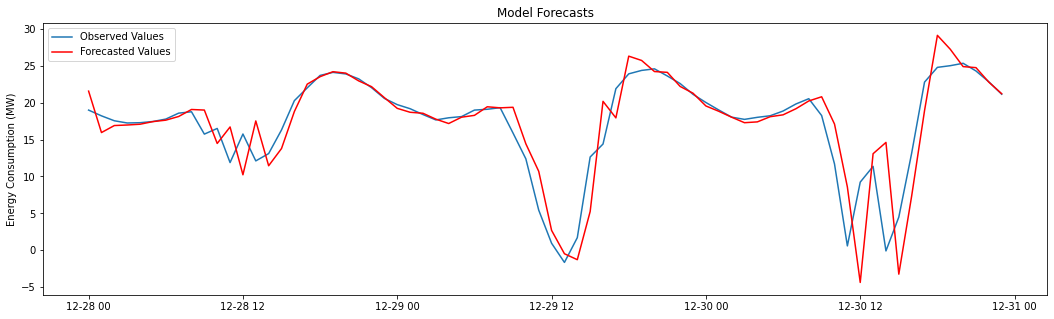

In [67]:
plt.plot(test_df['Interface'], label='Observed Values')
plt.plot(ar_pred_series, color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.show()

In [68]:
sarimax_model = SARIMAX(history, 
        order=(5,1,2),
        seasonal_order=(0,0,0,0),
        exogenous=ex_history)
    
sarimax_model_fit = sarimax_model.fit()
predictions = sarimax_model_fit.predict(start =len(train_df), end=len(train_df)+len(test_df),exog=test_df['Local Generation'])

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.74449D+00    |proj g|=  1.03152D+00


 This problem is unconstrained.



At iterate    5    f=  2.42287D+00    |proj g|=  9.15891D-02

At iterate   10    f=  2.41198D+00    |proj g|=  1.23548D-02

At iterate   15    f=  2.39651D+00    |proj g|=  9.55432D-02

At iterate   20    f=  2.34577D+00    |proj g|=  2.63632D-02

At iterate   25    f=  2.33304D+00    |proj g|=  2.82623D-02

At iterate   30    f=  2.32996D+00    |proj g|=  1.39596D-03

At iterate   35    f=  2.32996D+00    |proj g|=  8.62490D-05

At iterate   40    f=  2.32995D+00    |proj g|=  1.10505D-03

At iterate   45    f=  2.32985D+00    |proj g|=  3.73792D-03

At iterate   50    f=  2.32969D+00    |proj g|=  7.62516D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

/Users/diogoalves/miniforge3/envs/tensorflow/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


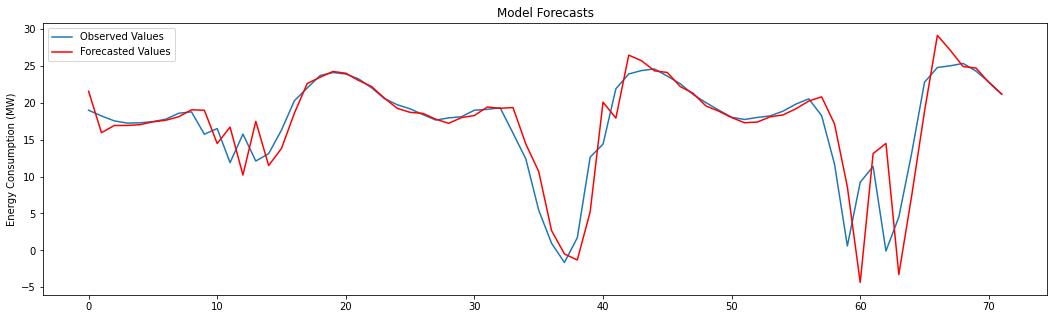

In [69]:
plt.plot(test_df['Interface'].values, label='Observed Values')
plt.plot(predictions[:len(test_df)], color='red', label='Forecasted Values')
plt.legend()
plt.title('Model Forecasts')
plt.ylabel('Energy Consumption (MW)')
plt.savefig(f'{SAVE_DIR}/sarimax_forecast.png')
plt.show()

In [70]:
rmse = np.sqrt(np.mean(predictions[:len(test_df)] - test_df['Interface'])**2)
rmse

0.1482162413239626

In [71]:
MAPE = np.mean(np.abs((test_df['Interface'].values - predictions[:len(test_df)]) / test_df['Interface'].values)) * 100
MAPE

269.29333224884766

# Let's Inspect Volatility

In [72]:
from statsmodels.stats.diagnostic import het_arch

arch_test = het_arch(sarima_residuals, maxlag=50)

print(f'Lagrange multiplier p-value: {arch_test[1]}')
print(f'F test p-value: {arch_test[3]}')

# p-val = 0 -> presence of heteroskedasticity in the residuals

Lagrange multiplier p-value: 0.0
F test p-value: 0.0


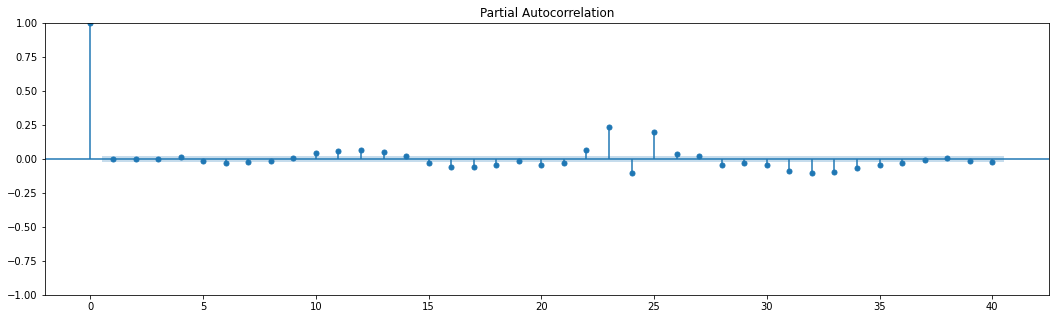

In [73]:
plot_pacf(sarima_residuals)
plt.show()

# Fit Garch Model on Residuals

In [74]:
import arch

garch = arch.arch_model(sarima_residuals, vol='EGARCH', p=1, q=1)
garch_fitted = garch.fit()

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6316204164236.509
Iteration:      2,   Func. Count:     15,   Neg. LLF: 150746471955.9302
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1875454.1854666285
Iteration:      4,   Func. Count:     32,   Neg. LLF: 38744.906155548386
Iteration:      5,   Func. Count:     38,   Neg. LLF: 60558405602.39692
Iteration:      6,   Func. Count:     45,   Neg. LLF: 16145.871206935699
Iteration:      7,   Func. Count:     50,   Neg. LLF: 16110.382400866229
Iteration:      8,   Func. Count:     55,   Neg. LLF: 16099.05720130392
Iteration:      9,   Func. Count:     60,   Neg. LLF: 16097.337038286336
Iteration:     10,   Func. Count:     65,   Neg. LLF: 16097.21784425522
Iteration:     11,   Func. Count:     70,   Neg. LLF: 16097.213312264608
Iteration:     12,   Func. Count:     75,   Neg. LLF: 16097.212153432803
Iteration:     13,   Func. Count:     80,   Neg. LLF: 16097.211879805707
Iteration:     14,   Func. Count:     85,   Neg. LLF: 16

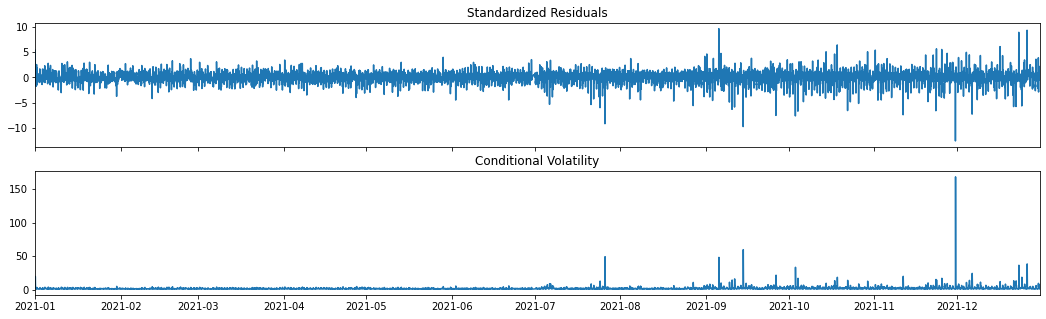

In [75]:
garch_fitted.plot()
plt.savefig(f'{SAVE_DIR}/garch_volatility.png')
plt.show()

In [76]:
new_df['first_difference'] = new_df['Interface'] - new_df['Interface'].shift()

[]

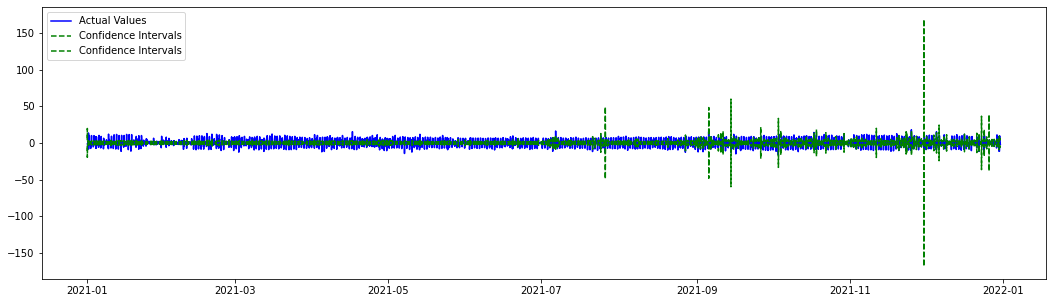

In [77]:
plt.rcParams["figure.figsize"] = 18, 5
plt.plot(new_df['first_difference'], color = "blue", label = "Actual Values")
plt.plot(garch_fitted.conditional_volatility,color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(-garch_fitted.conditional_volatility,color = "green", linestyle = "--", label = "Confidence Intervals")
plt.legend()
plt.savefig(f'{SAVE_DIR}/garch_and_series.png')
plt.plot()

# Part 2 - Recurrent Neural Networks Fit

# Train Test Split

In [78]:
BEGIN_TRAIN_DATE = datetime(2021, 1, 1)
END_TRAIN_DATE = datetime(2021, 12, 1)
BEGIN_TEST_DATE = datetime(2021, 12, 1)
END_TEST_DATE = datetime(2021, 12, 14)
BEGIN_FORECAST_DATE = datetime(2021, 12, 14)
END_FORECAST_DATE = datetime(2021, 12, 31)

train_df = new_df.loc[(new_df.index >= BEGIN_TRAIN_DATE) & (new_df.index < END_TRAIN_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]
train_series_data = new_df.loc[(new_df.index >= BEGIN_TRAIN_DATE) & (new_df.index < END_TRAIN_DATE)][['Interface', 'Local Generation']]

test_df = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]
test_series_data = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface', 'Local Generation']]

plot_df = new_df.loc[(new_df.index >= BEGIN_TEST_DATE) & (new_df.index < END_TEST_DATE)][['Interface']]

forecast_data = new_df.loc[(new_df.index >= BEGIN_FORECAST_DATE) & (new_df.index < END_FORECAST_DATE)][['Interface', 'Local Generation', 'is_workday', 'season_of_year']]



In [79]:
garch_pred_volatility = np.array([garch_fitted.conditional_volatility]).reshape(-1,1)
train_volatility_garch = garch_pred_volatility[0: len(train_df), :]
test_volatility_garch = garch_pred_volatility[len(train_df):len(train_df)+len(test_df), :]
forecast_volatility_garch = garch_pred_volatility[len(train_df)+len(test_df):len(train_df)+len(test_df)+len(forecast_data), :]

print(train_volatility_garch.shape, test_volatility_garch.shape, forecast_volatility_garch.shape)


(8016, 1) (312, 1) (408, 1)


In [80]:
# Append 'is workday' and 'season_of_year' to volatility data - [volatility, is_workday, seaso_of_year]
train_volatility_garch = np.column_stack((train_volatility_garch,train_df['is_workday'].values,train_df['season_of_year'].values))
test_volatility_garch = np.column_stack((test_volatility_garch, test_df['is_workday'].values,test_df['season_of_year'].values))
forecast_volatility_garch = np.column_stack((forecast_volatility_garch, forecast_data['is_workday'].values, forecast_data['season_of_year'].values))


# Scale Data

In [81]:
scaler_1 = MinMaxScaler(feature_range=(0,1))
scaler_1.fit(train_volatility_garch)

garch_train_scaled_data = scaler_1.transform(train_volatility_garch)
garch_test_scaled_data = scaler_1.transform(test_volatility_garch)
garch_forecast_scaled_data = scaler_1.transform(forecast_volatility_garch)

In [82]:
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaler_2.fit(train_df)

train_scaled_data = scaler_2.transform(train_df)
test_scaled_data = scaler_2.transform(test_df)
forecast_scaled_data = scaler_2.transform(forecast_data)

In [83]:
scaler_3 = MinMaxScaler(feature_range=(0,1))
scaler_3.fit(train_series_data)

train_series_scaled_data = scaler_3.transform(train_series_data)
test_series_scaled_data = scaler_3.transform(test_series_data)
forecast_series_scaled_data = scaler_3.transform(forecast_data[['Interface','Local Generation']].values)

# Create Sequences

In [84]:
def create_sequences(scaled_data, offset=168):
    # offset = Last 168 hours -> 7 days sequences
    
    num_features = scaled_data.shape[1]
    x = []
    y = []
    
    for i in range(offset, len(scaled_data)):
        x.append(scaled_data[i-offset:i,0:num_features])
        y.append(scaled_data[i,0])

    x = np.array(x)
    y = np.array(y).reshape(-1,1)
    
    return x, y

In [85]:
x_train, y_train = create_sequences(train_scaled_data)
x_test, y_test = create_sequences(test_scaled_data)

print(x_train.shape, x_test.shape)
print(y_train.shape, y_test.shape)

(7848, 168, 4) (144, 168, 4)
(7848, 1) (144, 1)


In [86]:
x_train_garch, _ = create_sequences(garch_train_scaled_data)
x_test_garch, _ = create_sequences(garch_test_scaled_data)

print(x_train_garch.shape, x_test_garch.shape)

(7848, 168, 3) (144, 168, 3)


In [87]:
x_train_series, _ = create_sequences(train_series_scaled_data)
x_test_series, _ = create_sequences(test_series_scaled_data)

print(x_train_series.shape, x_test_series.shape)

(7848, 168, 2) (144, 168, 2)


In [88]:
forecast_volatility, _ = create_sequences(garch_forecast_scaled_data)
forecast_data_, _ = create_sequences(forecast_scaled_data)
forecast_series_data, _ = create_sequences(forecast_series_scaled_data)

print(forecast_volatility.shape, forecast_data_.shape, forecast_series_data.shape)

(240, 168, 3) (240, 168, 4) (240, 168, 2)


In [89]:
# All Set and Ready to go!!

# Simple LSTM

In [90]:
model_1_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

lstm_layer_1 = LSTM(100, return_sequences=True, dropout=0.2)(model_1_input)
lstm_layer_2 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_1)
lstm_layer_3 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_2)
lstm_layer_4 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_3)
lstm_layer_5 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_4)
lstm_layer_6 = LSTM(100, dropout=0.2)(lstm_layer_5)

dense_1 = Dense(512, activation='relu')(lstm_layer_6)
dpout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(256, activation='relu')(dpout_1)
dpout_2 = Dropout(0.2)(dense_2)

output_layer = Dense(1, activation='linear')(dpout_2)

model_lstm = Model(inputs=model_1_input, outputs=output_layer)

Metal device set to: Apple M1


2022-06-19 12:26:33.040045: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-06-19 12:26:33.040121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [91]:
model_lstm.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [92]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10,
                                        restore_best_weights = True)

In [93]:
hist = model_lstm.fit(x_train, y_train,
            batch_size = 32,
            epochs = 100,
            callbacks=[earlystopping],
            validation_data=(x_test, y_test))

Epoch 1/100


2022-06-19 12:26:33.874546: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-06-19 12:26:37.085555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:26:37.634560: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:26:37.882061: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:26:38.105584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:26:38.328150: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:26:38.550549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

246/246 [==============================] - ETA: 0s - loss: 0.0301 - mse: 0.0601

2022-06-19 12:27:32.217816: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:27:32.405580: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:27:32.618460: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:27:32.833367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:27:33.049275: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:27:33.263283: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 12:27:33.478708: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - 61s 216ms/step - loss: 0.0301 - mse: 0.0601 - val_loss: 0.0177 - val_mse: 0.0354
Epoch 2/100
246/246 [==============================] - 46s 186ms/step - loss: 0.0244 - mse: 0.0487 - val_loss: 0.0180 - val_mse: 0.0361
Epoch 3/100
246/246 [==============================] - 47s 190ms/step - loss: 0.0242 - mse: 0.0484 - val_loss: 0.0179 - val_mse: 0.0359
Epoch 4/100
246/246 [==============================] - 47s 190ms/step - loss: 0.0241 - mse: 0.0482 - val_loss: 0.0174 - val_mse: 0.0348
Epoch 5/100
246/246 [==============================] - 47s 191ms/step - loss: 0.0238 - mse: 0.0477 - val_loss: 0.0169 - val_mse: 0.0338
Epoch 6/100
246/246 [==============================] - 48s 194ms/step - loss: 0.0231 - mse: 0.0462 - val_loss: 0.0162 - val_mse: 0.0325
Epoch 7/100
246/246 [==============================] - 48s 195ms/step - loss: 0.0214 - mse: 0.0427 - val_loss: 0.0170 - val_mse: 0.0340
Epoch 8/100
246/246 [==============================] - 48s 1

Epoch 61/100
246/246 [==============================] - 52s 210ms/step - loss: 0.0037 - mse: 0.0075 - val_loss: 0.0074 - val_mse: 0.0148
Epoch 62/100
246/246 [==============================] - 52s 211ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0077 - val_mse: 0.0154
Epoch 63/100
246/246 [==============================] - 52s 211ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0075 - val_mse: 0.0151
Epoch 64/100
246/246 [==============================] - 52s 211ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0073 - val_mse: 0.0146
Epoch 65/100
246/246 [==============================] - 52s 211ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0076 - val_mse: 0.0152
Epoch 66/100
246/246 [==============================] - 52s 210ms/step - loss: 0.0037 - mse: 0.0074 - val_loss: 0.0072 - val_mse: 0.0145
Epoch 67/100
246/246 [==============================] - 51s 208ms/step - loss: 0.0036 - mse: 0.0073 - val_loss: 0.0074 - val_mse: 0.0148
Epoch 68/100
246/246 [===================

In [94]:
y_pred = model_lstm.predict(x_test)

2022-06-19 13:37:04.310215: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:04.490768: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:04.715106: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:04.938953: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:05.163958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:05.390927: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:05.618137: I tensorflow/core/grappler/optimizers/cust

In [95]:
y_scaler = MinMaxScaler(feature_range=(0,1))
y_scaler.fit(train_df['Interface'].values.reshape(-1,1))

MinMaxScaler()

In [96]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.008410947016915206

In [97]:
y_pred = y_scaler.inverse_transform(y_pred)

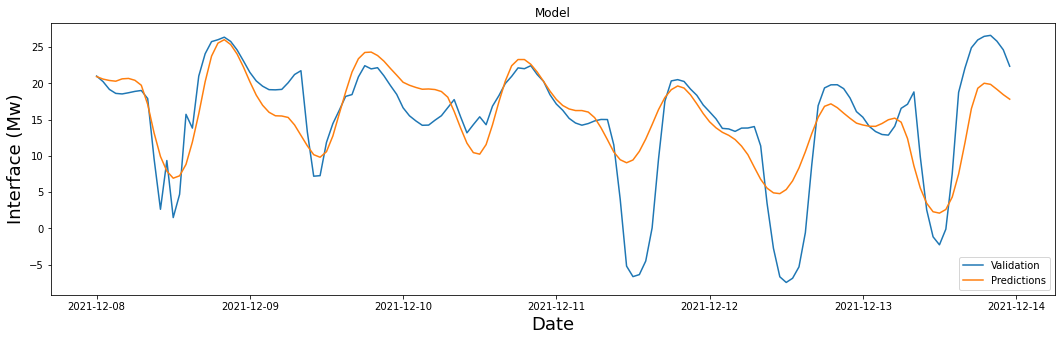

In [98]:
# Plot the data
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/lstm_forecast.png')
plt.show()

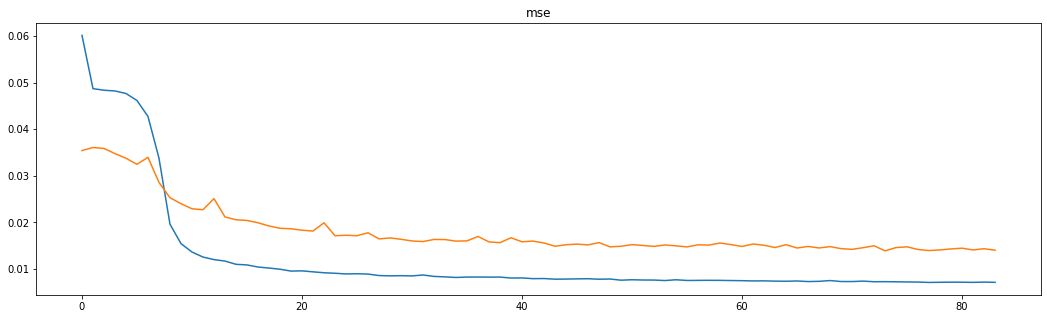

In [99]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/lstm_mse.png')
plt.show()

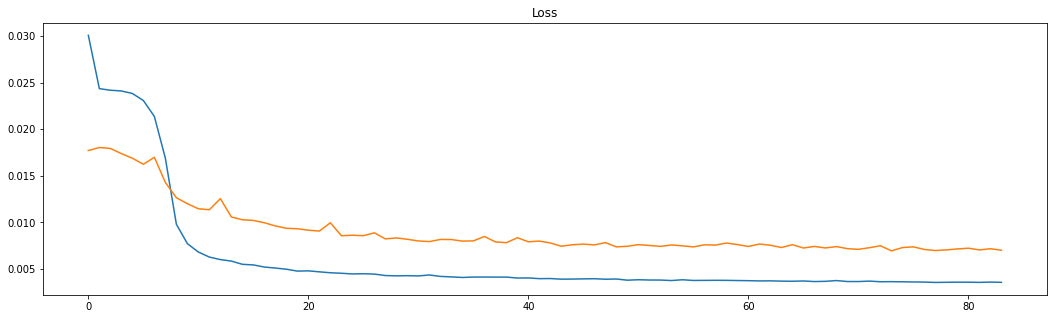

In [100]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/lstm_loss.png')
plt.show()

In [101]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

0.36516723728572403

In [102]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

202.5126388793166

# Bidirecional LSTM

In [103]:
model_1_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

lstm_layer_1 = LSTM(100, return_sequences=True, dropout=0.2)(model_1_input)
lstm_layer_2 = LSTM(100, return_sequences=True, dropout=0.2)(lstm_layer_1)

bidirectional_layer_1 = Bidirectional(LSTM(100, dropout=0.2, return_sequences=True, recurrent_dropout=0))(lstm_layer_2)
bidirectional_layer_2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_1)

dense_1 = Dense(512, activation='relu')(bidirectional_layer_2)
dpout_1 = Dropout(0.2)(dense_1)
dense_2 = Dense(256, activation='relu')(dpout_1)
dpout_2 = Dropout(0.2)(dense_2)

output_layer = Dense(1, activation='linear')(dpout_2)

model_bi_lstm = Model(inputs=model_1_input, outputs=output_layer)

In [104]:
model_bi_lstm.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [105]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10, 
                                        restore_best_weights = True)

In [106]:
hist = model_bi_lstm.fit(x_train, y_train,
        batch_size = 32, 
        epochs = 100,
        callbacks=[earlystopping],
        validation_data=(x_test, y_test))

Epoch 1/100


2022-06-19 13:37:11.941180: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:12.534843: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:12.776095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:13.013146: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:13.024962: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:13.388591: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:37:13.400122: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - ETA: 0s - loss: 0.0298 - mse: 0.0596

2022-06-19 13:38:12.509492: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:38:12.708197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:38:12.944400: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:38:13.174882: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:38:13.182777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:38:13.541071: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 13:38:13.549953: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - 67s 241ms/step - loss: 0.0298 - mse: 0.0596 - val_loss: 0.0171 - val_mse: 0.0341
Epoch 2/100
246/246 [==============================] - 54s 218ms/step - loss: 0.0226 - mse: 0.0452 - val_loss: 0.0170 - val_mse: 0.0341
Epoch 3/100
246/246 [==============================] - 54s 219ms/step - loss: 0.0183 - mse: 0.0366 - val_loss: 0.0146 - val_mse: 0.0292
Epoch 4/100
246/246 [==============================] - 54s 221ms/step - loss: 0.0129 - mse: 0.0259 - val_loss: 0.0118 - val_mse: 0.0237
Epoch 5/100
246/246 [==============================] - 54s 221ms/step - loss: 0.0088 - mse: 0.0177 - val_loss: 0.0110 - val_mse: 0.0219
Epoch 6/100
246/246 [==============================] - 55s 224ms/step - loss: 0.0071 - mse: 0.0141 - val_loss: 0.0111 - val_mse: 0.0222
Epoch 7/100
246/246 [==============================] - 55s 222ms/step - loss: 0.0065 - mse: 0.0129 - val_loss: 0.0101 - val_mse: 0.0202
Epoch 8/100
246/246 [==============================] - 55s 2

Epoch 61/100
246/246 [==============================] - 57s 231ms/step - loss: 0.0029 - mse: 0.0057 - val_loss: 0.0066 - val_mse: 0.0133
Epoch 62/100
246/246 [==============================] - 56s 229ms/step - loss: 0.0028 - mse: 0.0057 - val_loss: 0.0064 - val_mse: 0.0128
Epoch 63/100
246/246 [==============================] - 56s 228ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0064 - val_mse: 0.0127
Epoch 64/100
246/246 [==============================] - 56s 227ms/step - loss: 0.0028 - mse: 0.0057 - val_loss: 0.0068 - val_mse: 0.0136
Epoch 65/100
246/246 [==============================] - 56s 227ms/step - loss: 0.0028 - mse: 0.0056 - val_loss: 0.0063 - val_mse: 0.0126


In [107]:
y_pred = model_bi_lstm.predict(x_test)

2022-06-19 14:37:41.314163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:41.501846: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:41.749852: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:41.976650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:41.984510: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:42.348195: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:42.356595: I tensorflow/core/grappler/optimizers/cust

In [108]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.01763517695959357

In [109]:
y_pred = y_scaler.inverse_transform(y_pred)

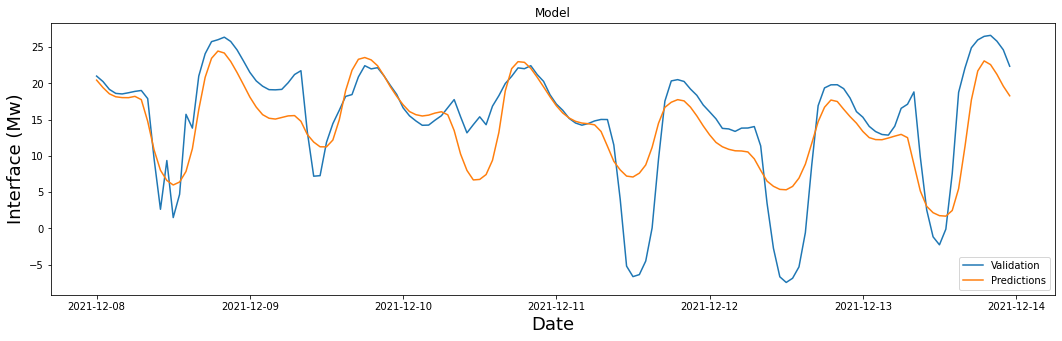

In [110]:
# Plot the data
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/bi_lstm_forecast.png')
plt.show()

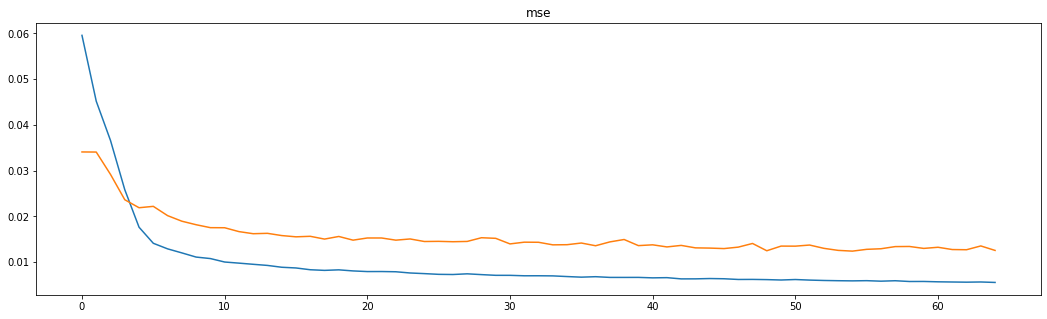

In [111]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/bi_lstm_mse.png')
plt.show()

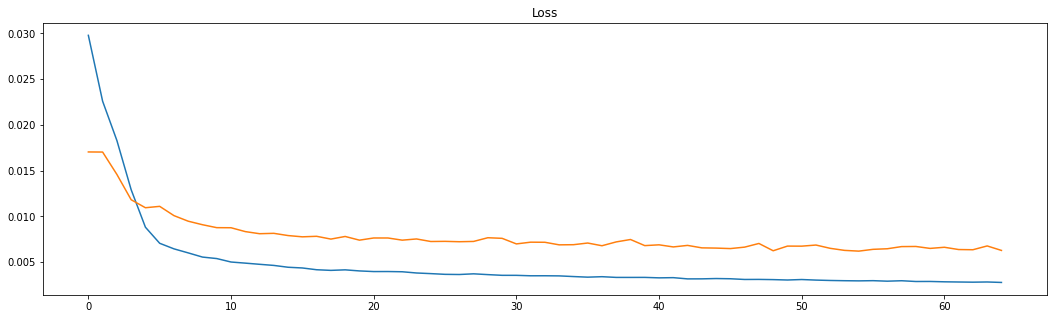

In [112]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/bi_lstm_loss.png')
plt.show()

In [113]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

0.7656448091427975

In [114]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

163.30106019642224

# Part 3 - Stack Convolutional Network + LSTM for Series Prediction + LSTM for Volatility Prediction

In [115]:
# First Model - Bidirectional LSTM for Time Series Forecasting
series_input = Input(shape=(x_train.shape[1], x_train.shape[2]))

bidirectional_layer_1 = Bidirectional(LSTM(100, dropout=0.2, return_sequences=True, recurrent_dropout=0))(series_input)
bidirectional_layer_2 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_1)

dense_1 = Dense(256, activation='relu')(bidirectional_layer_2)
dpout_1 = Dropout(0.2)(dense_1)

forecast_layer = Dense(1, activation='linear')(dpout_1)

# Second Model - Bidirectional LSTM for Volatility Forecasting
volatility_input = Input(shape=(x_train_garch.shape[1], x_train_garch.shape[2]))

bidirectional_layer_3 = Bidirectional(LSTM(100, dropout=0.2,return_sequences=True, recurrent_dropout=0))(volatility_input)
bidirectional_layer_4 = Bidirectional(LSTM(100, dropout=0.2, recurrent_dropout=0))(bidirectional_layer_3)

dense_3 = Dense(256, activation='relu')(bidirectional_layer_4)
dpout_3 = Dropout(0.2)(dense_3)
volatility_layer = Dense(1, activation='linear')(dpout_3)

# Third Model - 1D CNN for Time Series Feature Extraction
cnn_input = Input(shape=(x_train_series.shape[1], x_train_series.shape[2]))

conv_layer_1 = Conv1D(filters=64, 
                    kernel_size=3,
                    strides=1, 
                    padding="causal", 
                    activation='relu')(cnn_input)

pooling_layer_1 = MaxPooling1D(pool_size=2)(conv_layer_1)
dpout_pooling_1 = Dropout(0.2)(pooling_layer_1)

conv_layer_2 = Conv1D(filters=128, 
                    kernel_size=3,
                    strides=1, 
                    padding="causal", 
                    activation='relu')(dpout_pooling_1)

pooling_layer_2 = MaxPooling1D(pool_size=2)(conv_layer_2)
dpout_pooling_2 = Dropout(0.2)(pooling_layer_2)

flatten_layer = Flatten()(dpout_pooling_2)

dense_5 = Dense(128, activation='relu')(flatten_layer)
dpout_5 = Dropout(0.2)(dense_5)
dense_6 = Dense(128, activation='relu')(dpout_5)
dpout_6 = Dropout(0.2)(dense_6)

series_cnn_features = Dense(1, activation='linear')(dpout_6)

# Sum forecast and volatility
sum_forecast_and_volatility = Add()([forecast_layer, volatility_layer])

# Append Forecast+Volatility to CNN Extracted Features
concat_layer = concatenate([sum_forecast_and_volatility, series_cnn_features])

# Final Fully Connected Layer - concat_layer Interpretation
dense_final = Dense(128, activation='relu')(concat_layer)
dpout_6 = Dropout(0.2)(dense_final)

# Final Output Probability
output_layer = Dense(1, activation='linear')(dpout_6)

model = Model(inputs=[series_input, volatility_input, cnn_input], outputs=output_layer)


In [116]:
model.compile(optimizer=SGD(momentum=0.9), loss=tf.keras.losses.Huber(), metrics=['mse'])
#model.compile(optimizer=Adam(), loss=tf.keras.losses.Huber(), metrics=['mse'])

In [117]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", 
                                        patience = 10, 
                                        restore_best_weights = True)

In [118]:
hist = model.fit([x_train, x_train_garch, x_train_series], y_train,
        batch_size = 32,
        epochs = 200,
        callbacks=[earlystopping],
        validation_data=([x_test, x_test_garch, x_test_series], y_test))

Epoch 1/200


2022-06-19 14:37:50.153394: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:51.017594: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:51.022784: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:51.031853: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:51.035719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:51.721641: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:37:51.722192: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - ETA: 0s - loss: 0.0195 - mse: 0.0389

2022-06-19 14:39:09.837449: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:39:10.110620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:39:10.110640: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:39:10.119620: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:39:10.119642: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:39:10.796691: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 14:39:10.797072: I tensorflow/core/grappler/optimizers/cust

246/246 [==============================] - 88s 320ms/step - loss: 0.0195 - mse: 0.0389 - val_loss: 0.0090 - val_mse: 0.0180
Epoch 2/200
246/246 [==============================] - 71s 289ms/step - loss: 0.0053 - mse: 0.0105 - val_loss: 0.0095 - val_mse: 0.0190
Epoch 3/200
246/246 [==============================] - 71s 290ms/step - loss: 0.0046 - mse: 0.0093 - val_loss: 0.0081 - val_mse: 0.0162
Epoch 4/200
246/246 [==============================] - 72s 293ms/step - loss: 0.0043 - mse: 0.0086 - val_loss: 0.0077 - val_mse: 0.0155
Epoch 5/200
246/246 [==============================] - 72s 294ms/step - loss: 0.0040 - mse: 0.0080 - val_loss: 0.0081 - val_mse: 0.0162
Epoch 6/200
246/246 [==============================] - 73s 295ms/step - loss: 0.0038 - mse: 0.0076 - val_loss: 0.0079 - val_mse: 0.0158
Epoch 7/200
246/246 [==============================] - 73s 295ms/step - loss: 0.0036 - mse: 0.0071 - val_loss: 0.0071 - val_mse: 0.0143
Epoch 8/200
246/246 [==============================] - 72s 2

Epoch 61/200
246/246 [==============================] - 80s 327ms/step - loss: 0.0014 - mse: 0.0029 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 62/200
246/246 [==============================] - 79s 322ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0033 - val_mse: 0.0067
Epoch 63/200
246/246 [==============================] - 78s 319ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0030 - val_mse: 0.0061
Epoch 64/200
246/246 [==============================] - 79s 322ms/step - loss: 0.0014 - mse: 0.0027 - val_loss: 0.0030 - val_mse: 0.0060
Epoch 65/200
246/246 [==============================] - 79s 322ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0032 - val_mse: 0.0065
Epoch 66/200
246/246 [==============================] - 79s 321ms/step - loss: 0.0013 - mse: 0.0026 - val_loss: 0.0030 - val_mse: 0.0061
Epoch 67/200
246/246 [==============================] - 80s 326ms/step - loss: 0.0013 - mse: 0.0027 - val_loss: 0.0028 - val_mse: 0.0056
Epoch 68/200
246/246 [===================

In [119]:
y_pred = model.predict([x_test, x_test_garch, x_test_series])

2022-06-19 16:25:39.123958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 16:25:39.390282: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 16:25:39.390301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 16:25:39.400898: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 16:25:39.401733: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 16:25:40.167424: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-06-19 16:25:40.167750: I tensorflow/core/grappler/optimizers/cust

In [120]:
rmse = np.sqrt(np.mean(y_pred - y_test)**2)
rmse

0.0003300501319694613

In [121]:
y_pred = y_scaler.inverse_transform(y_pred)

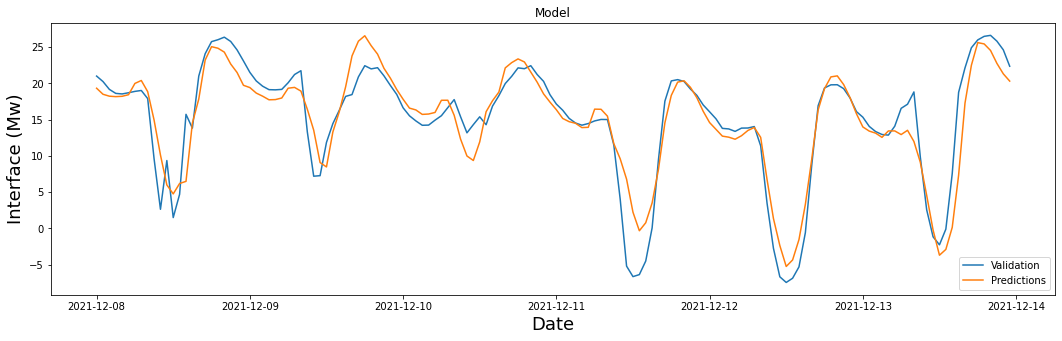

In [122]:
interface_data = plot_df.filter(['Interface'])
valid = interface_data[-x_test.shape[0]:]
valid['Predictions'] = y_pred

plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.plot(valid[['Interface', 'Predictions']])
plt.legend(['Validation', 'Predictions'], loc='lower right')
plt.savefig(f'{SAVE_DIR}/model_forecast.png')
plt.show()

In [123]:
rmse = np.sqrt(np.mean(valid['Predictions'] - valid['Interface'])**2)
rmse

0.014329739137042842

In [124]:
MAPE = np.mean(np.abs((valid['Interface'] - valid['Predictions']) / valid['Interface'])) * 100
MAPE

78.93671300957655

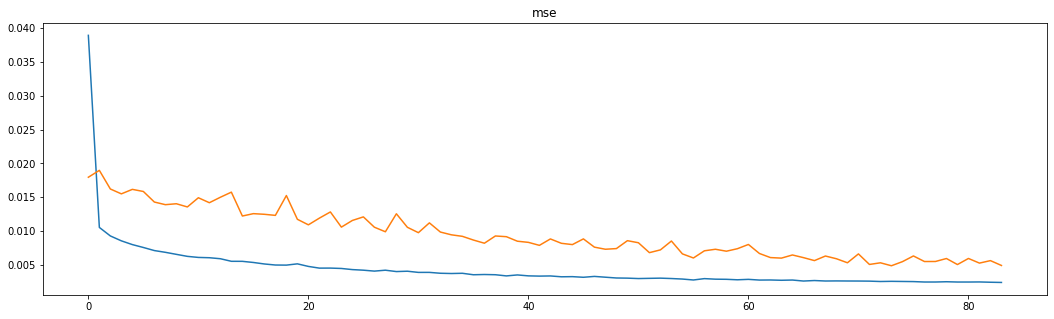

In [125]:
plt.plot(hist.history['mse'])
plt.plot(hist.history['val_mse'])
plt.title('mse')
plt.savefig(f'{SAVE_DIR}/model_mse.png')
plt.show()

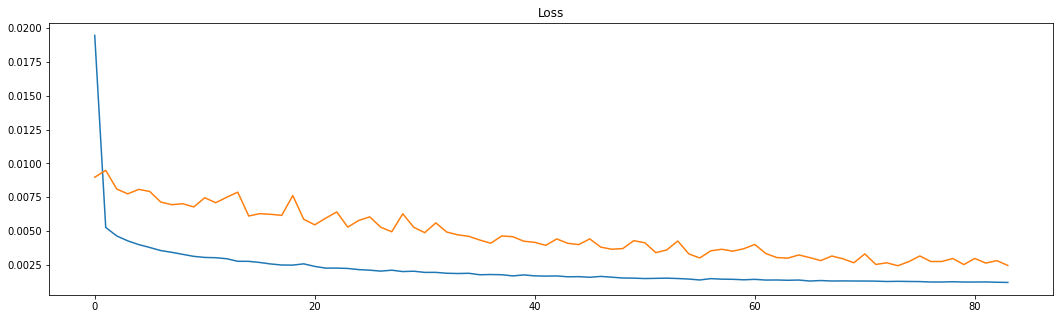

In [126]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.savefig(f'{SAVE_DIR}/model_loss.png')
plt.show()

# Forecast

In [127]:
FUTURE = 167 # Amount of hours to predict
output = []
x_forecast = np.reshape(forecast_data_[0],(1, forecast_data_[0].shape[0], forecast_data_[0].shape[1]))
series_forecast = np.reshape(forecast_series_data[0],(1, forecast_series_data[0].shape[0], forecast_series_data[0].shape[1]))

for i in range(FUTURE):
    volatility_forecast = np.reshape(forecast_volatility[i],(1, forecast_volatility[i].shape[0], forecast_volatility[i].shape[1]))
    
    y_forecast = model.predict([x_forecast, volatility_forecast, series_forecast])[0][0]
    
    # Eliminate 'Interface' data from next sequence and append predicted value instead
    # example:
    # [interface, local generation, is_workday, season_of_year] -> [local generation, is_workday, season_of_year]
    # [local generation, is_workday, season_of_year] -> [interface prediction, local generation, is_workday, season_of_year]
    pred_data = np.append(y_forecast, forecast_data_[0][i,-3:])
    pred_series = np.append(y_forecast, forecast_series_data[0][i, 1])
    
    # Append the last sequence to the next sequence and eliminate the older
    # example:
    # [1,2,3] - p1
    # [2,3, p1] - p2
    # [3, p1, p2] - p3
    x_forecast = np.vstack((forecast_data_[i,:][1:], pred_data))
    series_forecast = np.vstack((forecast_series_data[i,:][1:], pred_series))
    
    # Reshape to get a (BATCH_SIZE, 168 , NUMBER_OF_FEATURES) -> LSTM input shape
    x_forecast = np.reshape(x_forecast,(1, x_forecast.shape[0], x_forecast.shape[1]))
    series_forecast = np.reshape(series_forecast,(1, series_forecast.shape[0], series_forecast.shape[1]))
    
    output.append(y_forecast) 
    

In [128]:
forecast_prediction = y_scaler.inverse_transform(np.array(output).reshape(-1,1))

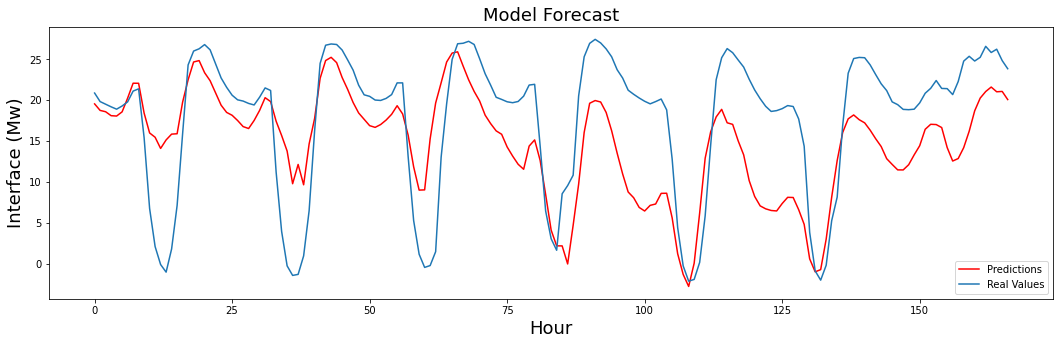

In [136]:
plt.plot(forecast_prediction, color='red')
plt.plot(forecast_data['Interface'].values[:FUTURE])
plt.savefig(f'{SAVE_DIR}/model_final_forecast.png')
plt.title('Model Forecast', fontsize=18)
plt.xlabel('Hour', fontsize=18)
plt.ylabel('Interface (Mw)', fontsize=18)
plt.legend(['Predictions', 'Real Values'], loc='lower right')
plt.show()

In [130]:
rmse = np.sqrt(np.mean(forecast_prediction - forecast_data['Interface'].values[:FUTURE])**2)
rmse

3.00318159920465

In [131]:
MAPE = np.mean(np.abs((forecast_data['Interface'].values[:FUTURE] - forecast_prediction) / forecast_data['Interface'].values[:FUTURE])) * 100
MAPE

431.1661094413071